### Import dependencies

In [2]:
# import dependencies
import os
import seaborn as sns
from datetime import datetime
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


### Set globl varables

In [3]:
START = datetime(2016, 1, 1)
END = datetime(2021, 2, 16)
BUCKET = 1  # day

### Load Data

In [4]:
# Load data
global_markets_volumes_path = "data/VOLUMES.csv"
vix_path = "data/VIX.csv"
sp500_path = "data/SP500.csv"
gold_path= "data/GOLD.csv"
euro_usd_path = "data/EURUSD.csv"
bonds_path = "data/10YBONDYIELDS.csv"

In [5]:
def load_data(path: str, target:str) -> pd.DataFrame:
    assert target in ["gm", "vix", "sp500", "gold", "eurusd", "bonds"], f"Invaid target: {target}"

    root = os.path.dirname(os.getcwd())
    df = pd.read_csv(f"{root}/{path}")

    # rename columns to lower case
    df.columns = map(str.lower, df.columns)
    if target == "gm":
        index = "business date"
    else:
        index = "date"
    new_columns = ["date"] + [column + f"_{target}" for column in df.columns if column != index]
    # Add _target to columns except Date
    df.rename(columns=dict(zip(df.columns, new_columns)),inplace=True)
    # Remove space from columns
    df.columns = df.columns.str.replace(" ", "_")
    return df.set_index("date")

def join_dfs(df_list: List) -> pd.DataFrame:
    pdf = df_list[0]
    for df in df_list[1:]:
        pdf = pdf.join(df, how="left")
    assert len(pdf) == len(df_list[0])
    return pdf

In [6]:
gm_volumes = load_data(global_markets_volumes_path, "gm")
vix = load_data(vix_path, "vix")
sp500 = load_data(sp500_path, "sp500")
gold = load_data(gold_path, "gold")
euro_usd = load_data(euro_usd_path, "eurusd")
bonds = load_data(bonds_path, "bonds")

In [7]:
all_dfs = [gm_volumes, vix, sp500, gold, euro_usd, bonds]
all_data = join_dfs(all_dfs)
all_data

volume_gm  vix_close_vix  adj_close_sp500  volume_sp500  \
date                                                                   
1/4/2016   1364.873049          20.70      2012.660034  4.304880e+09   
1/5/2016   4826.624586          19.34      2016.709961  3.706620e+09   
1/6/2016   1751.952884          20.59      1990.260010  4.336660e+09   
1/7/2016   5842.829025          24.99      1943.089966  5.076590e+09   
1/8/2016   1592.794266          27.01      1922.030029  4.664940e+09   
...                ...            ...              ...           ...   
2/10/2021  3190.066116          21.99      3909.879883  4.815380e+09   
2/11/2021  2427.720356          21.25      3916.379883  4.570080e+09   
2/12/2021  3232.310708          19.97      3934.830078  4.119260e+09   
2/15/2021  1950.728704            NaN              NaN           NaN   
2/16/2021  3023.560878          21.46      3932.590088  5.037360e+09   

           adj_close_gold  volume_gold  usd_eurusd  adj_close_bonds  \
date                                                                  
1/4/2016      1075.099976        143.0      1.0898            2.245   
1/5/2016      1078.400024         82.0      1.0746            2.248   
1/6/2016      1091.900024         52.0      1.0742            2.177   
1/7/2016      1107.699951        122.0      1.0868            2.153   
1/8/2016      1097.800049         98.0      1.0861            2.130   
...                   ...          ...         ...              ...   
2/10/2021     1840.599976        543.0      1.2127            1.133   
2/11/2021     1824.900024        602.0      1.2147            1.158   
2/12/2021     1821.599976        259.0      1.2108            1.200   
2/15/2021             NaN          NaN      1.2129              NaN   
2/16/2021     1797.199951       1141.0      1.2143            1.299   

           volume_bonds  
date                     
1/4/2016            0.0  
1/5/2016            0.0  
1/6/2016            0.0  
1/7/2016            0.0  
1/8/2016            0.0  
...                 ...  
2/10/2021           0.0  
2/11/2021           0.0  
2/12/2021           0.0  
2/15/2021           NaN  
2/16/2021           0.0  

[1328 rows x 9 columns]

### EDA

#### Check for missing values

In [8]:
# Check missing values
# Use interpolate
# Drop bonds as they add no data
all_data[all_data.isna().any(axis=1)]

volume_gm  vix_close_vix  adj_close_sp500  volume_sp500  \
date                                                                    
1/18/2016   1245.635545            NaN              NaN           NaN   
2/15/2016   1070.457234            NaN              NaN           NaN   
3/25/2016      2.655447            NaN              NaN           NaN   
3/28/2016     28.294602          15.24      2037.050049  2.809090e+09   
5/30/2016    484.661910            NaN              NaN           NaN   
...                 ...            ...              ...           ...   
11/26/2020  3013.808951            NaN              NaN           NaN   
11/27/2020  3520.232596          20.84      3638.350098  2.778450e+09   
12/24/2020   936.569447          21.53      3703.060059  1.885090e+09   
1/18/2021   8820.536954            NaN              NaN           NaN   
2/15/2021   1950.728704            NaN              NaN           NaN   

            adj_close_gold  volume_gold  usd_eurusd  adj_close_bonds  \
date                                                                   
1/18/2016              NaN          NaN      1.0892              NaN   
2/15/2016              NaN          NaN      1.1180              NaN   
3/25/2016              NaN          NaN         NaN              NaN   
3/28/2016      1219.900024         33.0         NaN             1.87   
5/30/2016              NaN          NaN      1.1139              NaN   
...                    ...          ...         ...              ...   
11/26/2020             NaN          NaN      1.1900              NaN   
11/27/2020             NaN          NaN      1.1922              NaN   
12/24/2020             NaN          NaN      1.2193              NaN   
1/18/2021              NaN          NaN      1.2064              NaN   
2/15/2021              NaN          NaN      1.2129              NaN   

            volume_bonds  
date                      
1/18/2016            NaN  
2/15/2016            NaN  
3/25/2016            NaN  
3/28/2016            0.0  
5/30/2016            NaN  
...                  ...  
11/26/2020           NaN  
11/27/2020           NaN  
12/24/2020           NaN  
1/18/2021            NaN  
2/15/2021            NaN  

[64 rows x 9 columns]

<Axes: xlabel='date'>

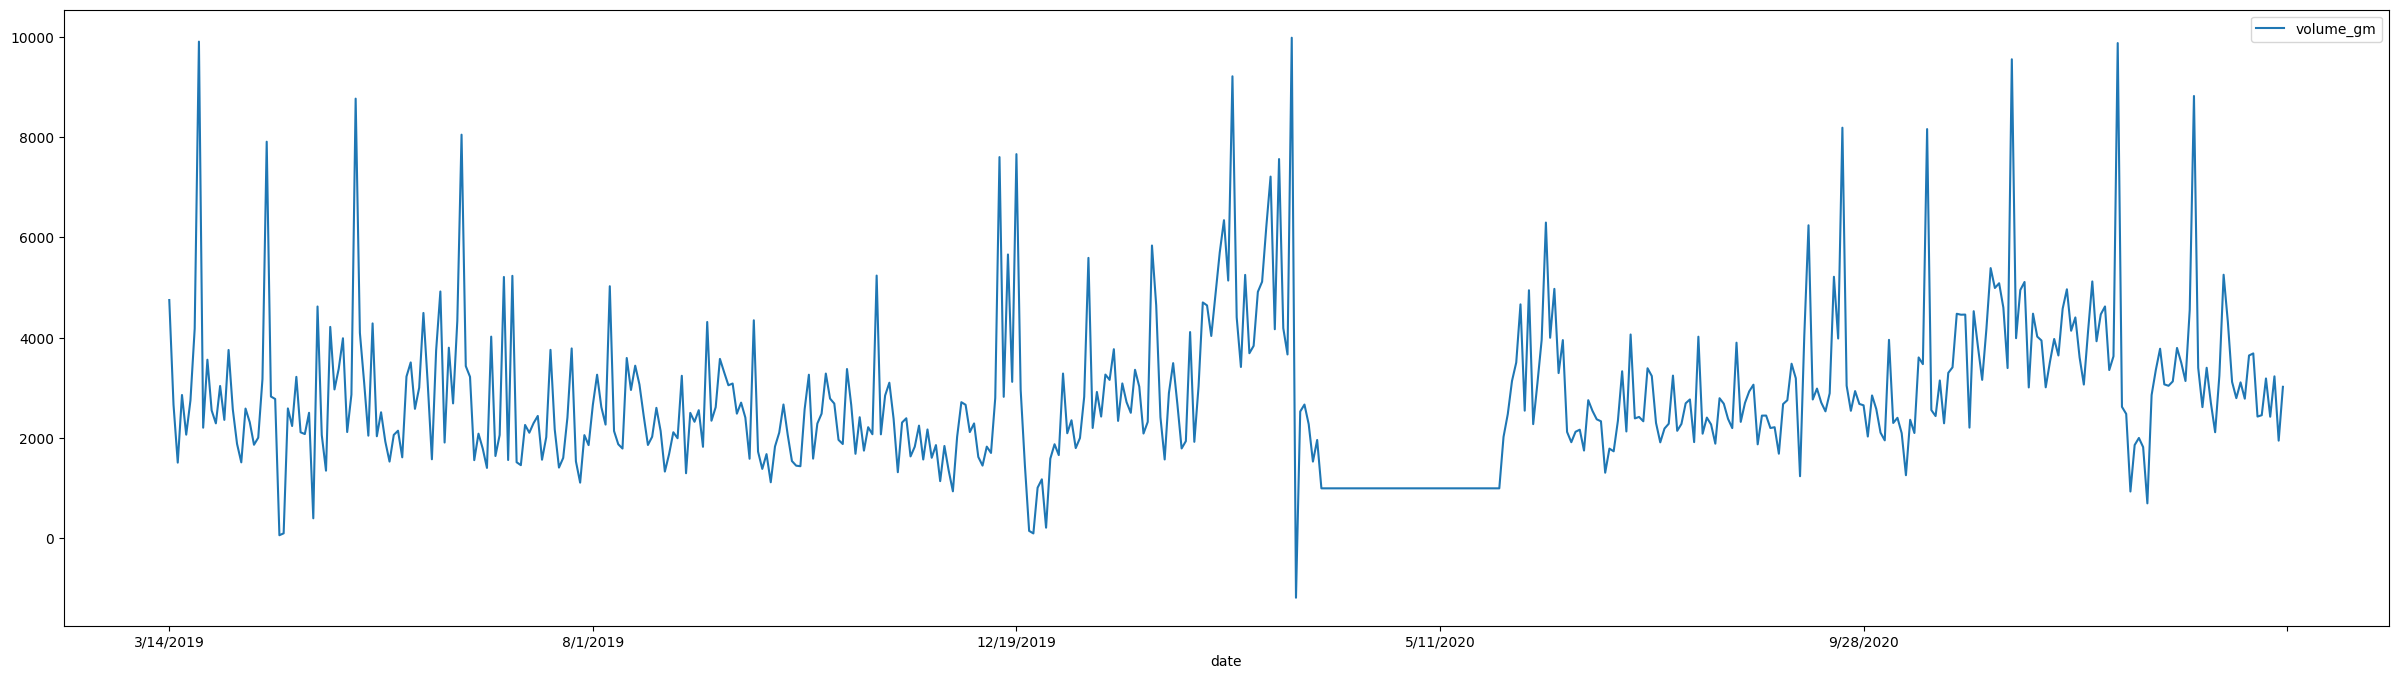

In [9]:
# No trend
# Yes seasonality around 30 days**
# remove flat part
all_data.iloc[-500:].plot(y='volume_gm', figsize=[30, 8])

<Axes: xlabel='date'>

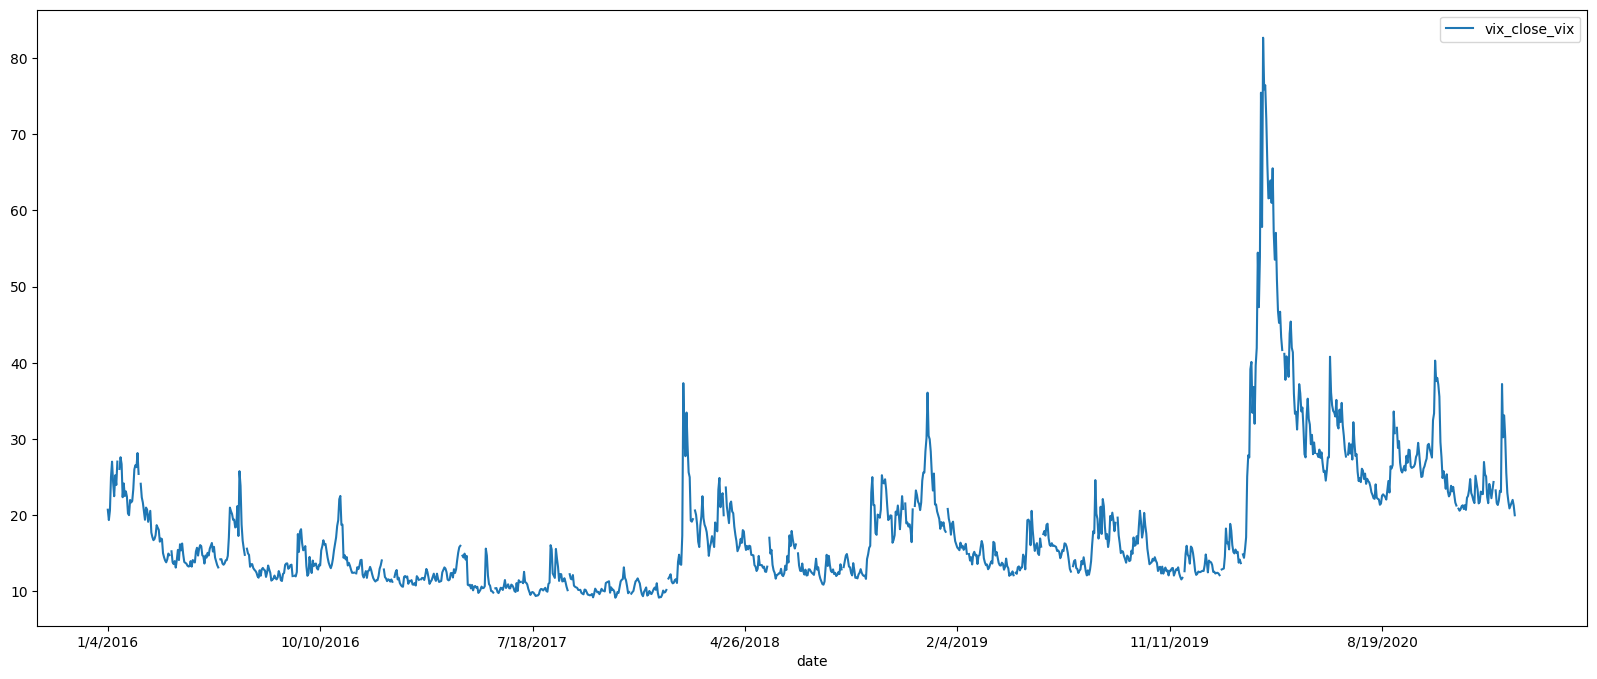

In [10]:
# Remove outliers
all_data.plot(y='vix_close_vix', figsize=[20, 8])

<Axes: xlabel='date'>

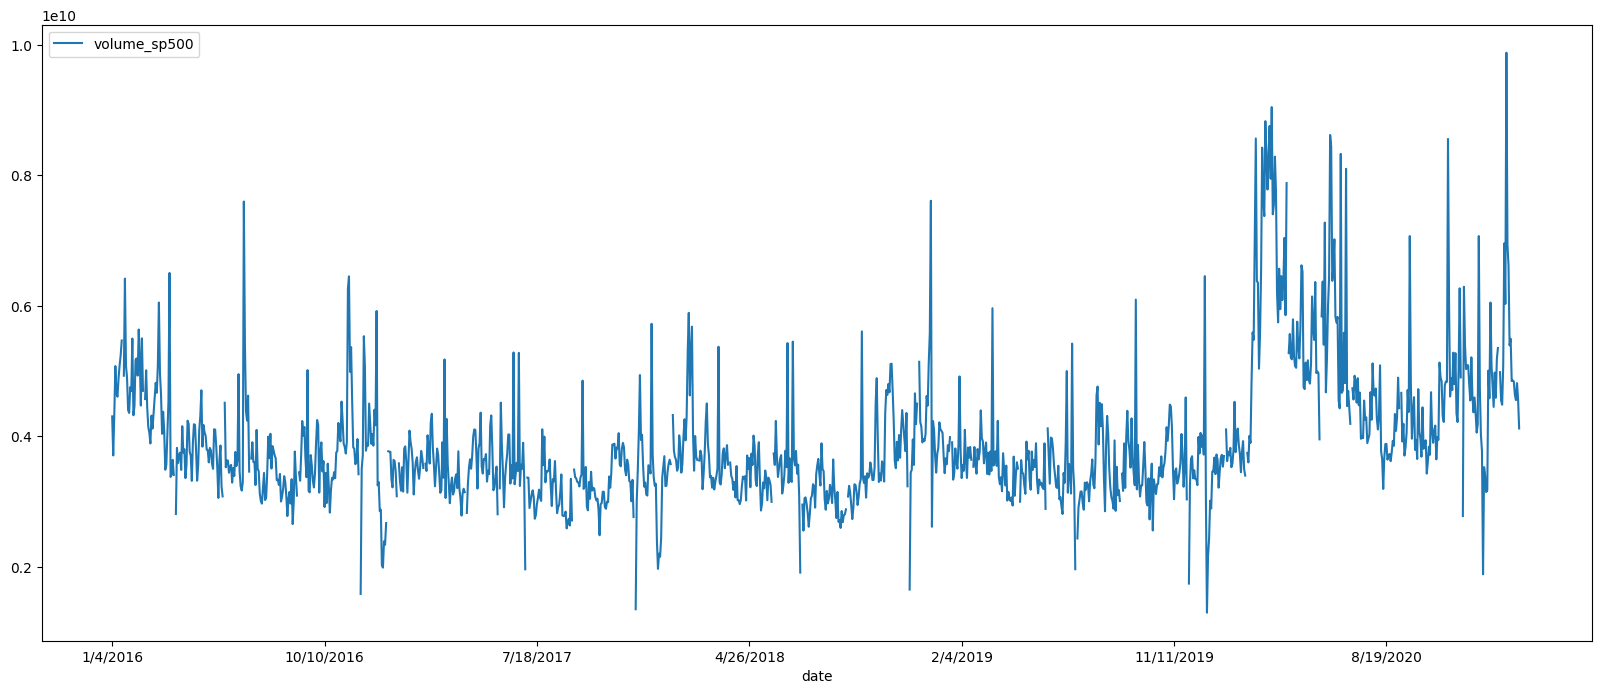

In [11]:
all_data.plot(y='volume_sp500', figsize=[20, 8])

<Axes: xlabel='date'>

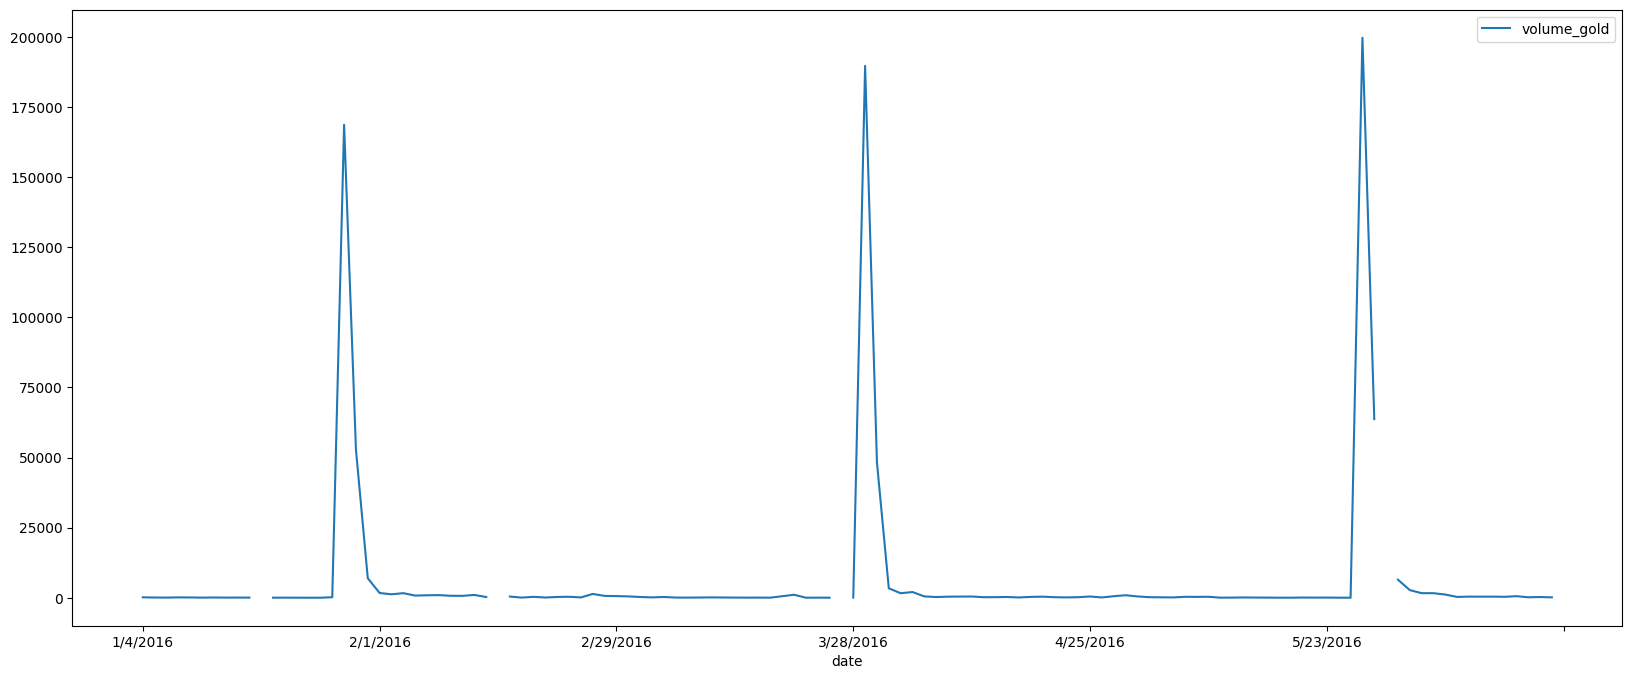

In [12]:
# Use??
# If use then remove seasonality
all_data.iloc[:120].plot(y='volume_gold', figsize=[20, 8])

<Axes: xlabel='date'>

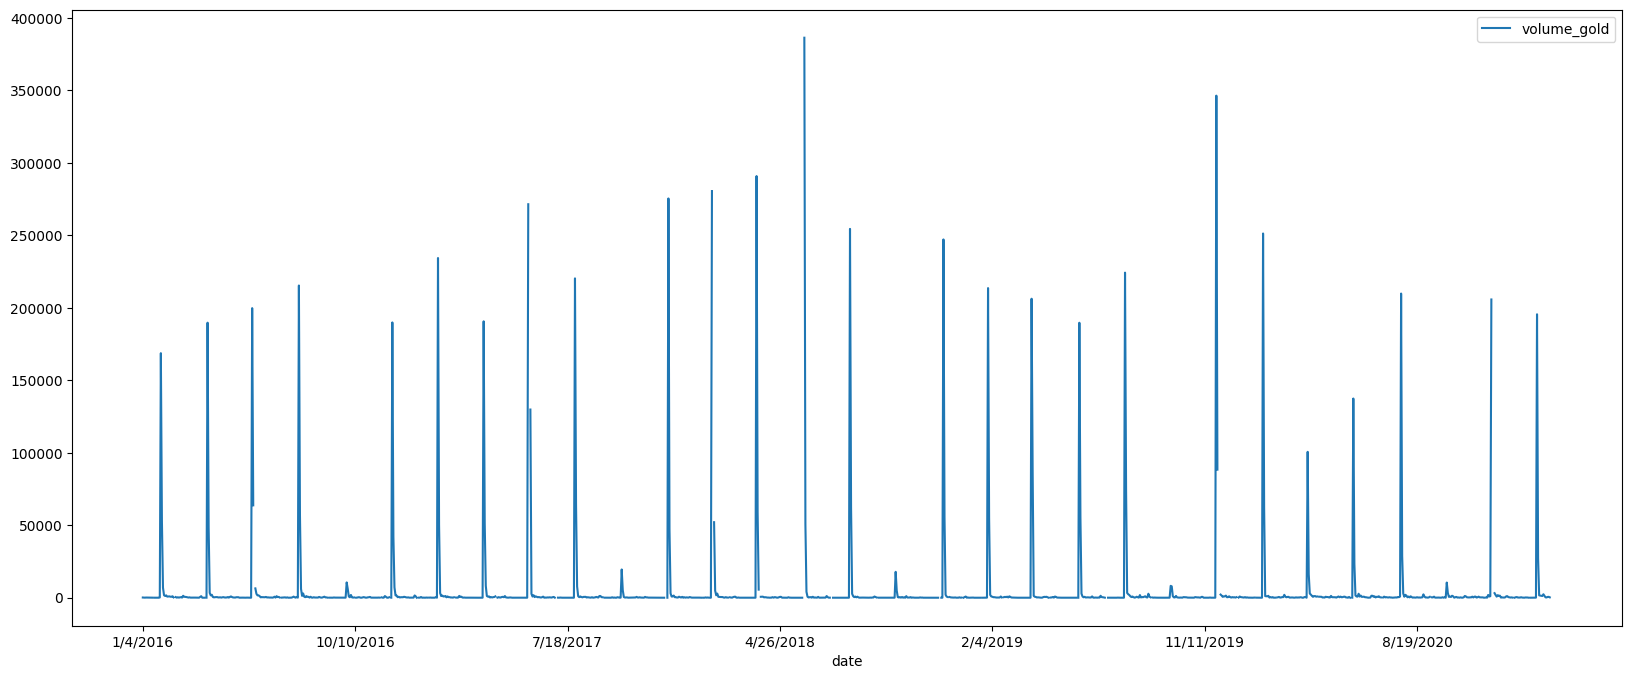

In [13]:
# Clear seasonality
all_data.plot(y='volume_gold', figsize=[20, 8])

<Axes: xlabel='date'>

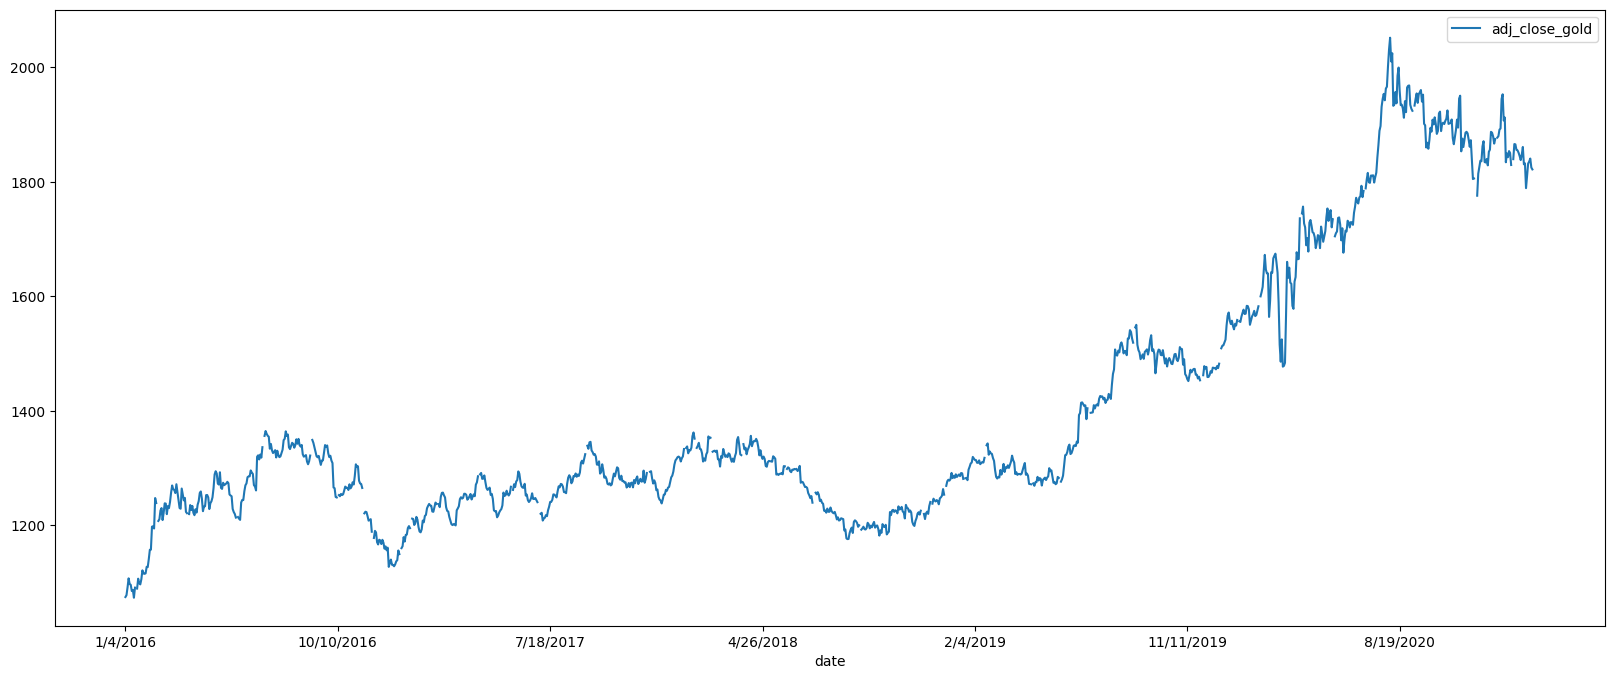

In [14]:
# Ascending trend
# Remove trend
all_data.plot(y='adj_close_gold', figsize=[20, 8])

<Axes: xlabel='date'>

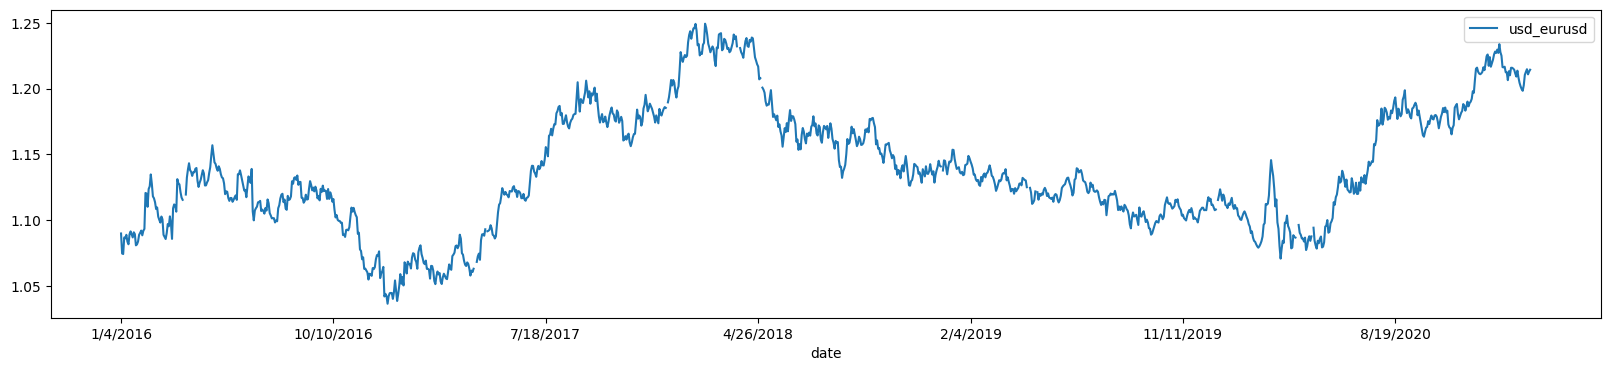

In [15]:
all_data.plot(y='usd_eurusd', figsize=[20, 4])

<Axes: xlabel='date'>

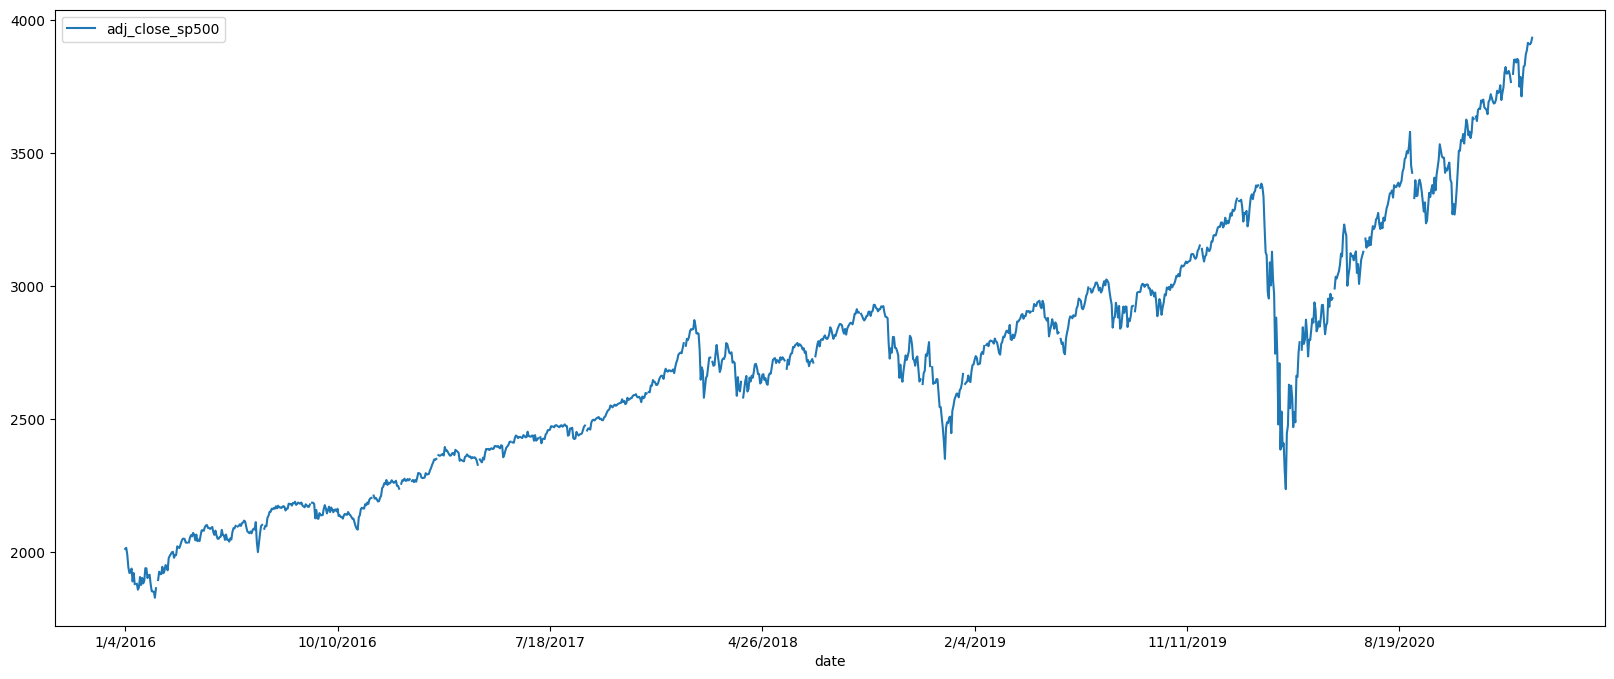

In [16]:
# Ascending trend
# Remove trend
all_data.plot(y='adj_close_sp500', figsize=[20, 8])

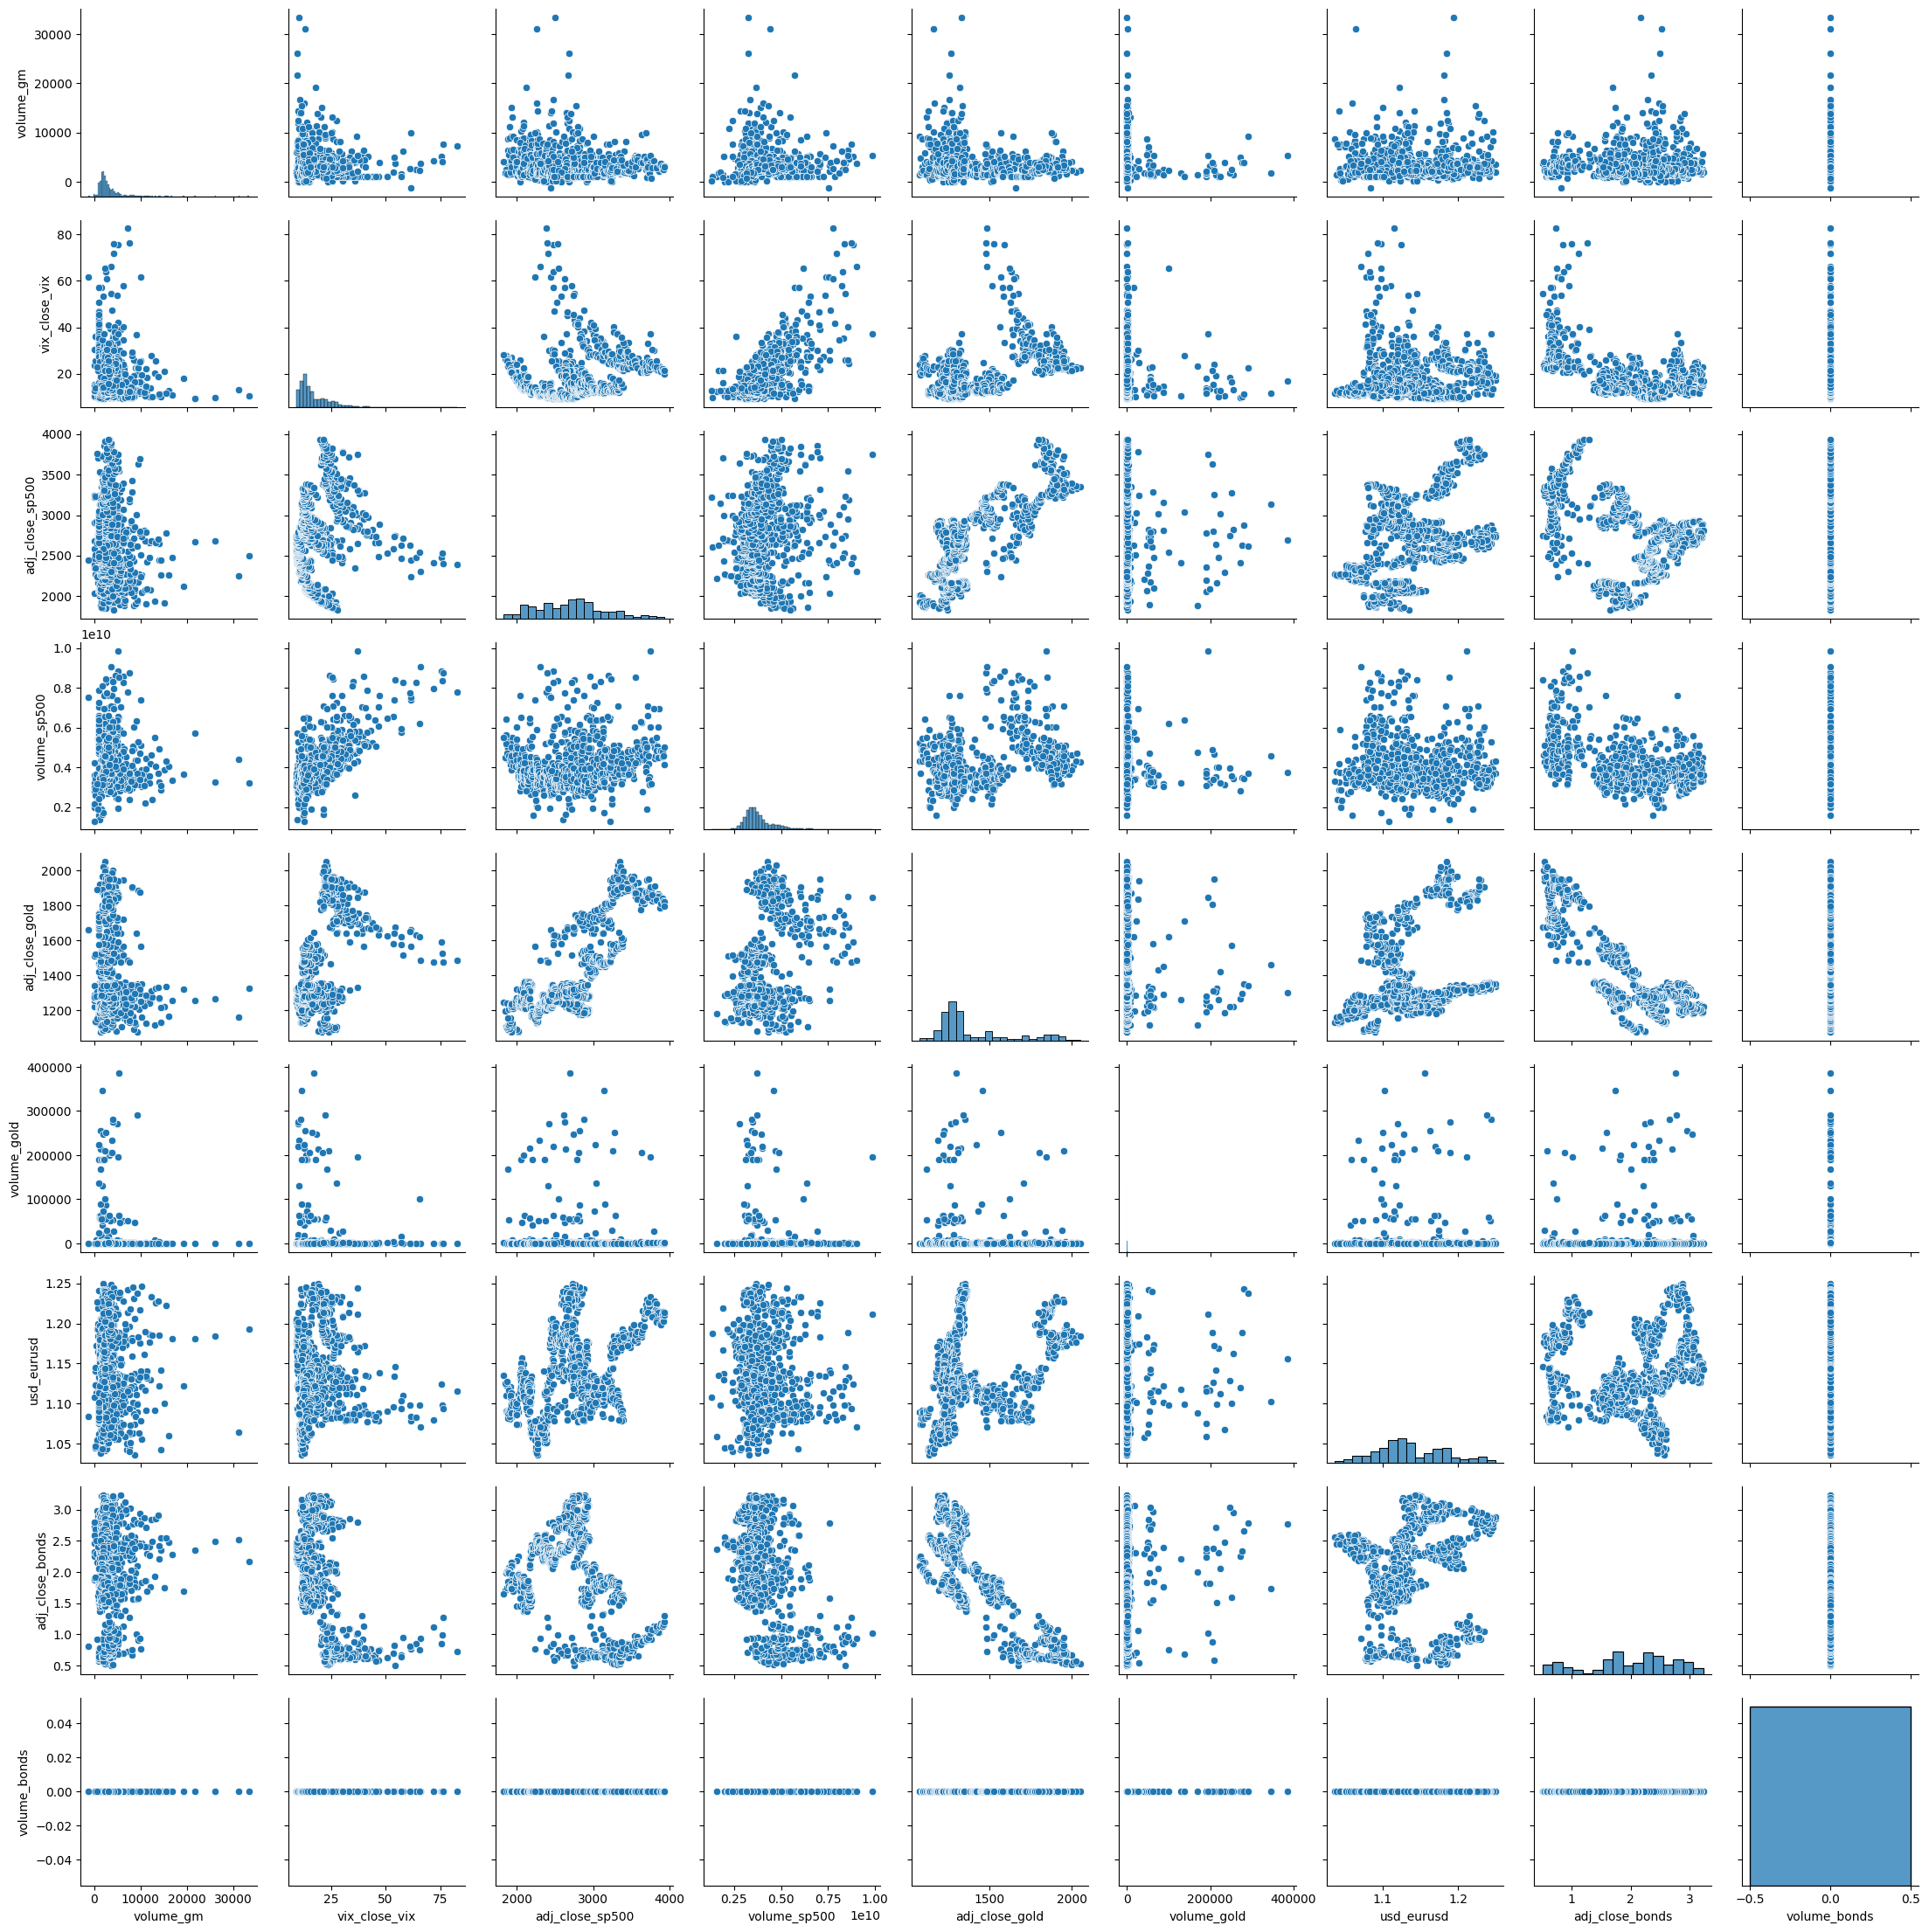

In [17]:
sns.pairplot(all_data)

#### Plot autocorrelation 

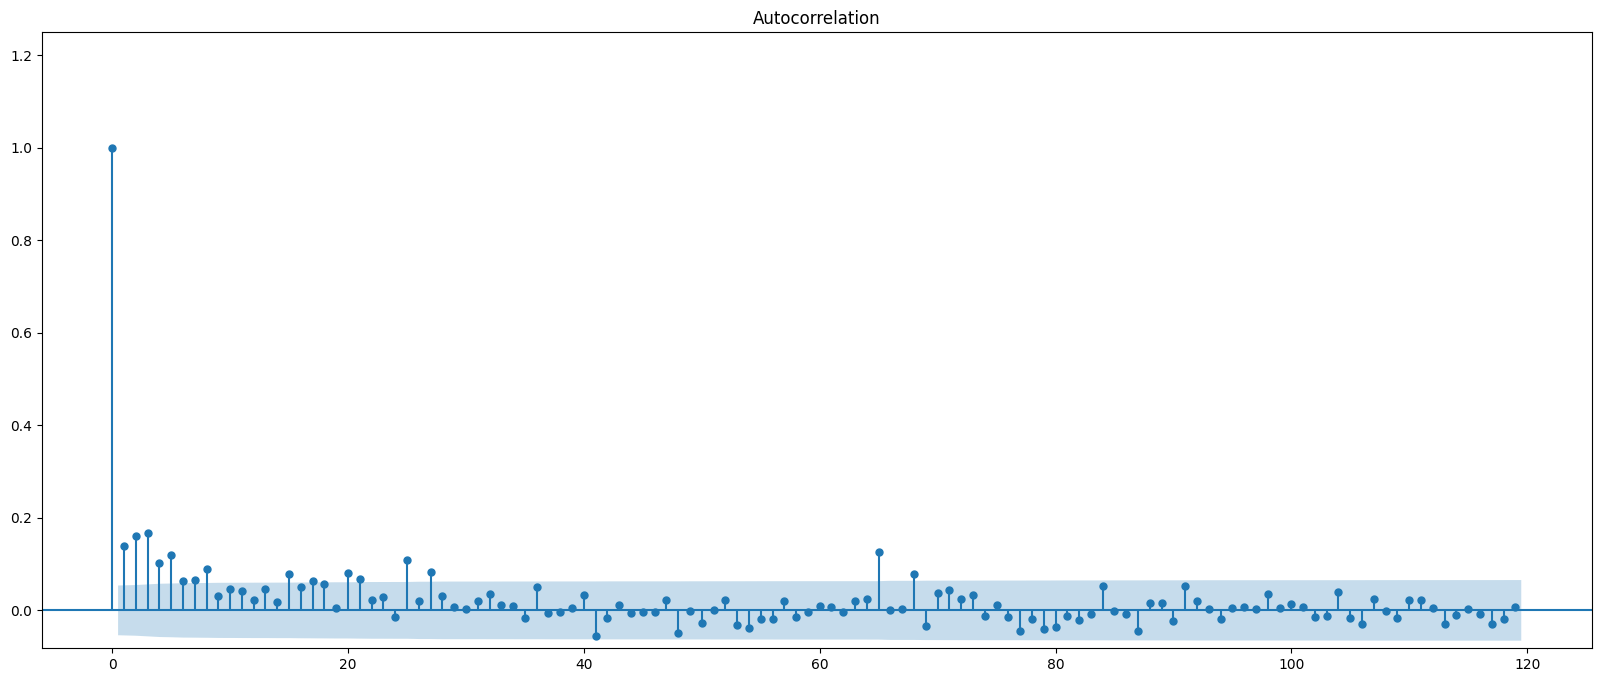

In [18]:
# VOLUME_GM
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(all_data['volume_gm'], 
                    ax = ax, 
                    lags = np.arange(120), 
                    auto_ylims = True)

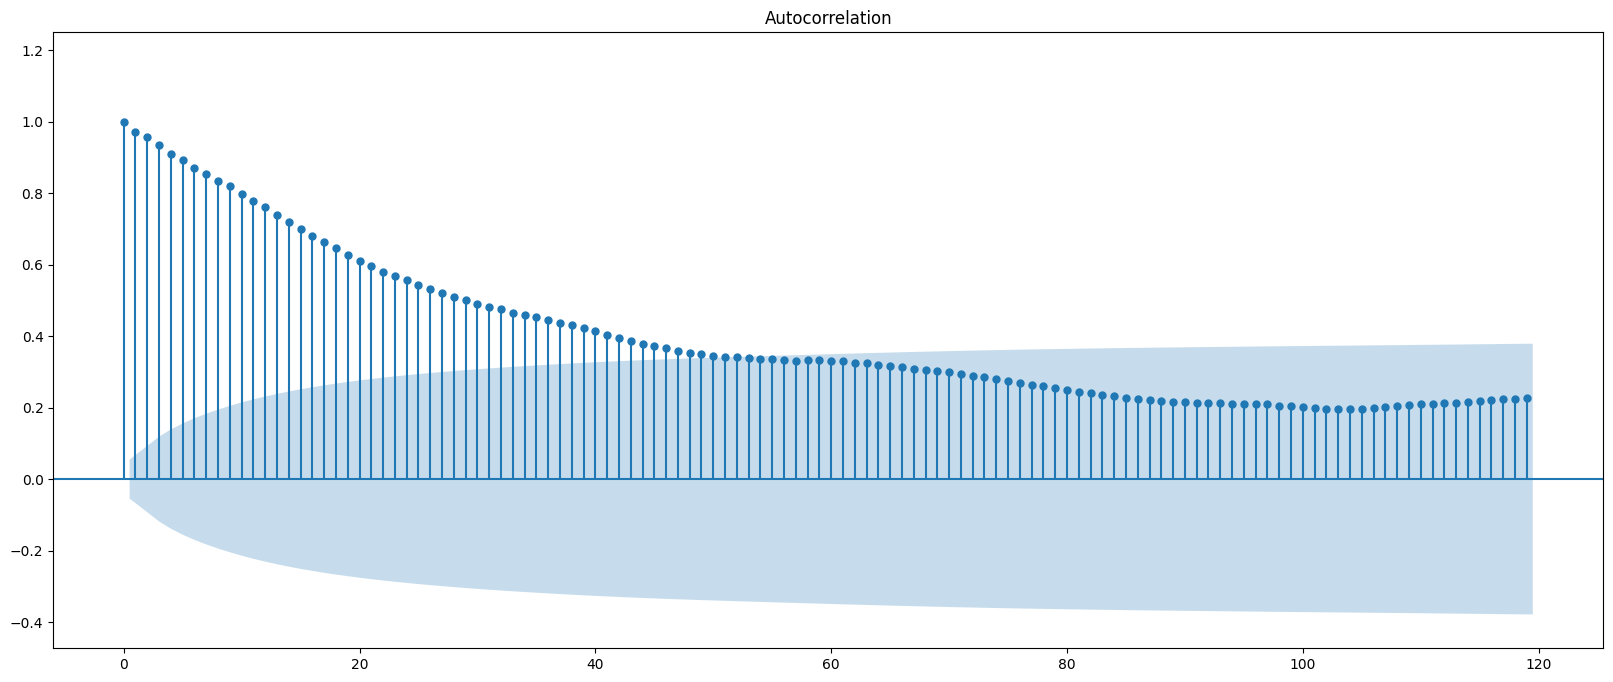

In [19]:
# VIX
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(all_data['vix_close_vix'].dropna(), 
                    ax = ax, 
                    lags = np.arange(120), 
                    auto_ylims = True)

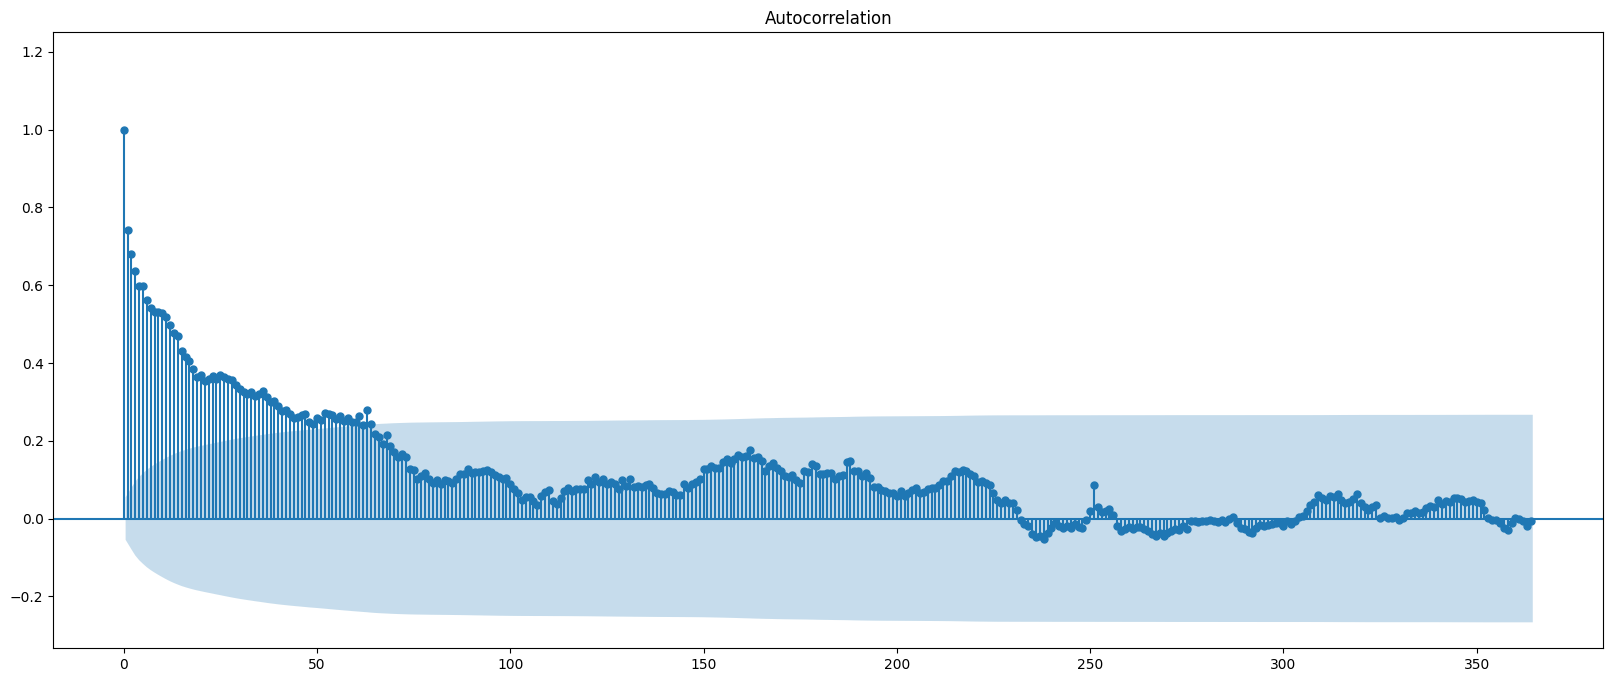

In [30]:
# VOLUME_SP500
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(all_data[["volume_sp500"]].dropna(), 
                    ax = ax, 
                    lags = np.arange(365), 
                    auto_ylims = True)

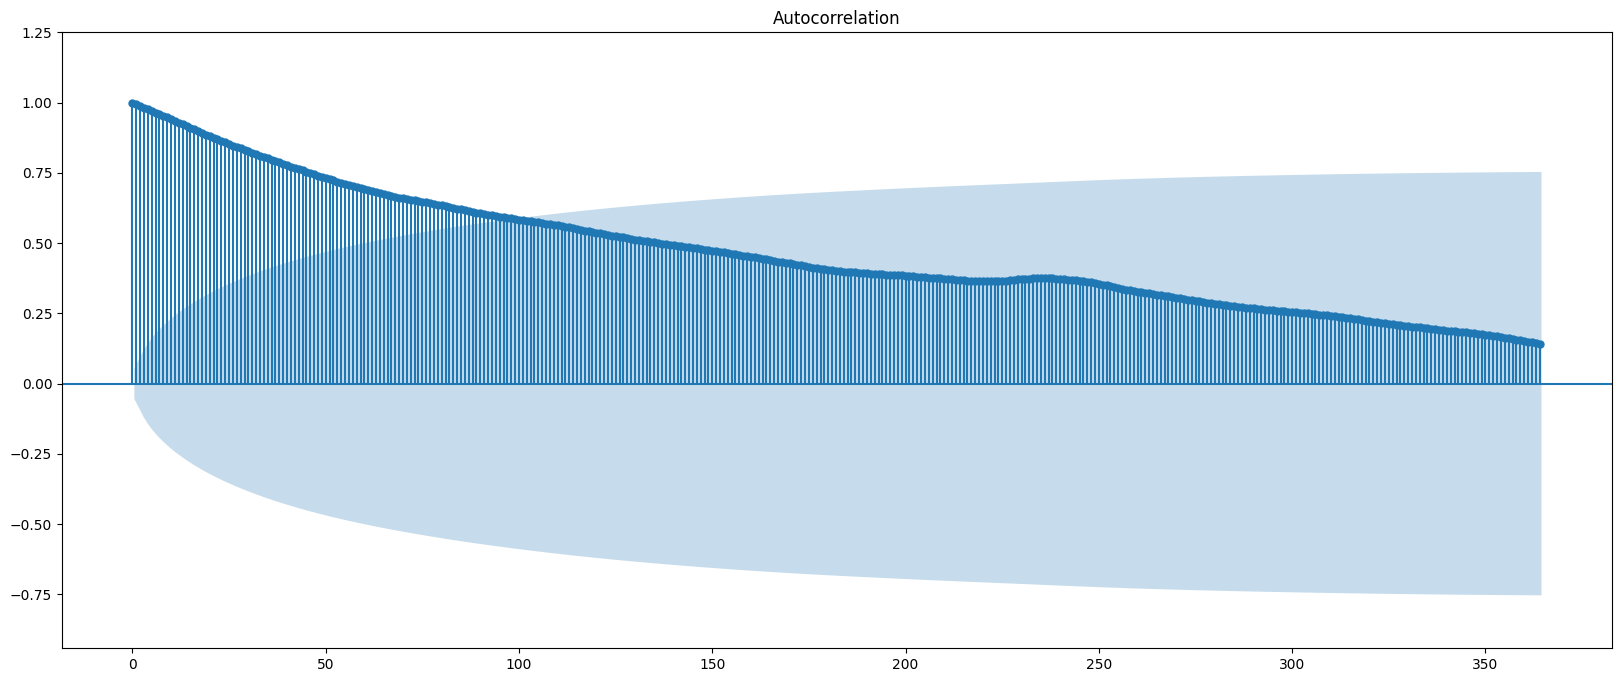

In [94]:
# VOLUME_ADJ_CLOSE_SP
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(all_data[["adj_close_sp500"]].dropna(), 
                    ax = ax, 
                    lags = np.arange(365), 
                    auto_ylims = True)

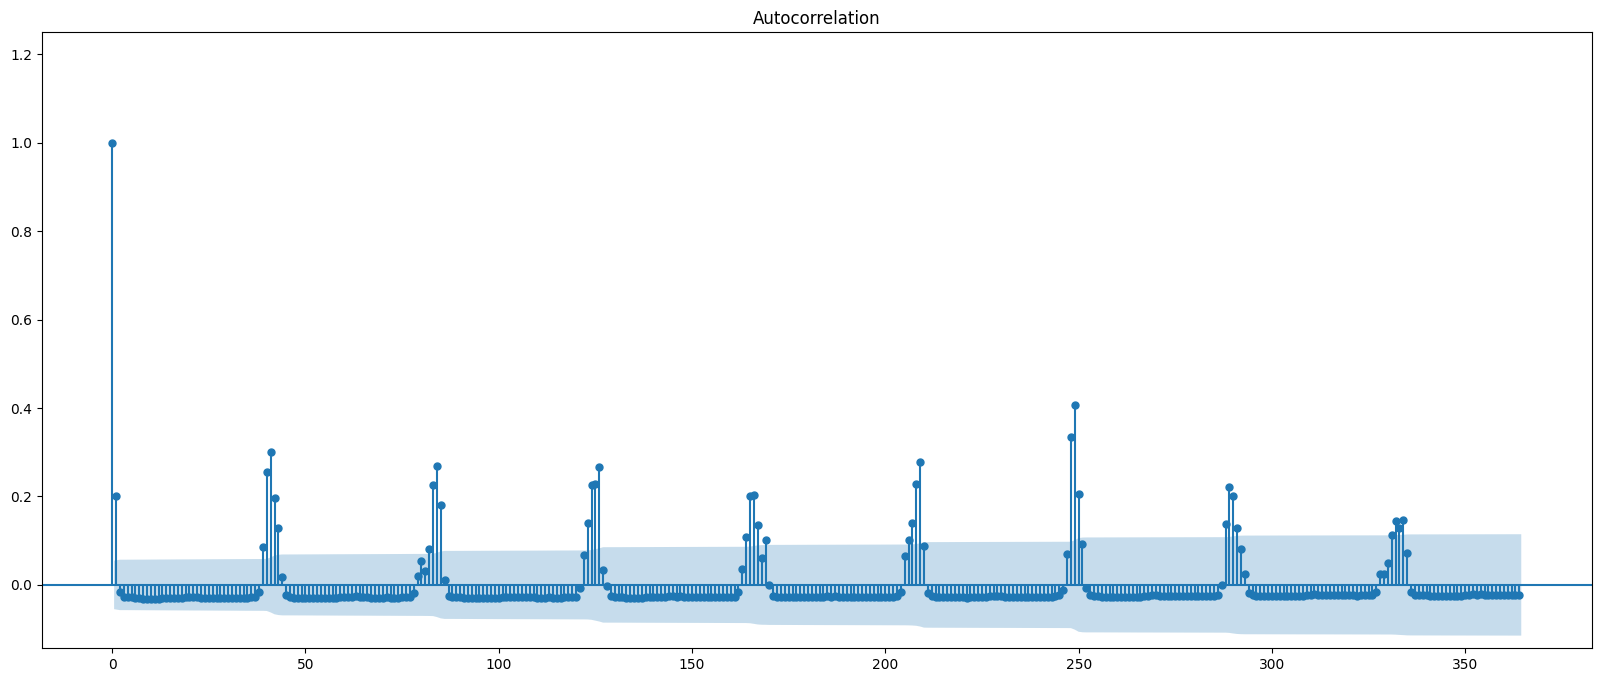

In [29]:
# VOLUME_GOLD
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(all_data[["volume_gold"]].dropna(), 
                    ax = ax, 
                    lags = np.arange(365), 
                    auto_ylims = True)

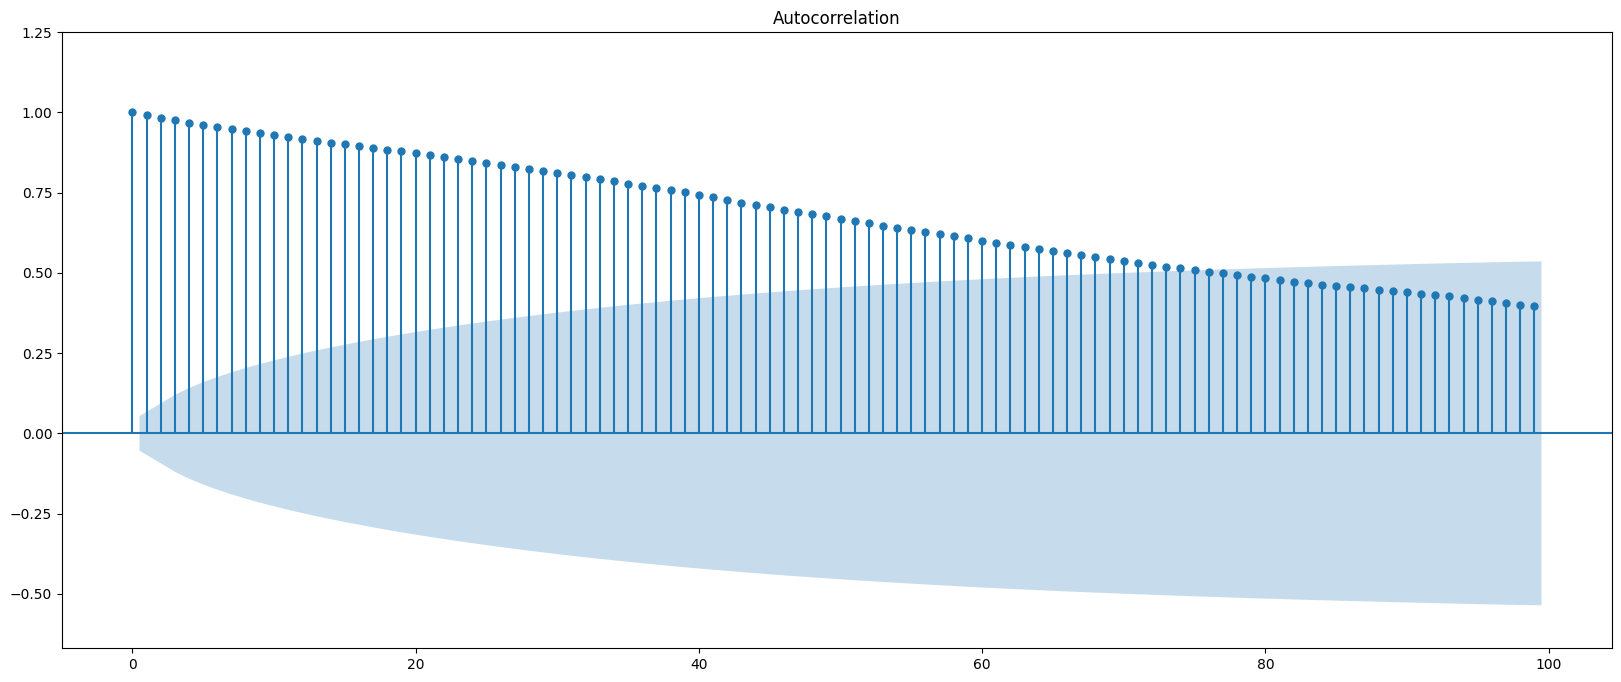

In [91]:
# VOLUME_USD
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(all_data[["usd_eurusd"]].dropna(), 
                    ax = ax, 
                    lags = np.arange(100), 
                    auto_ylims = True)

#### Plot parcial correlation

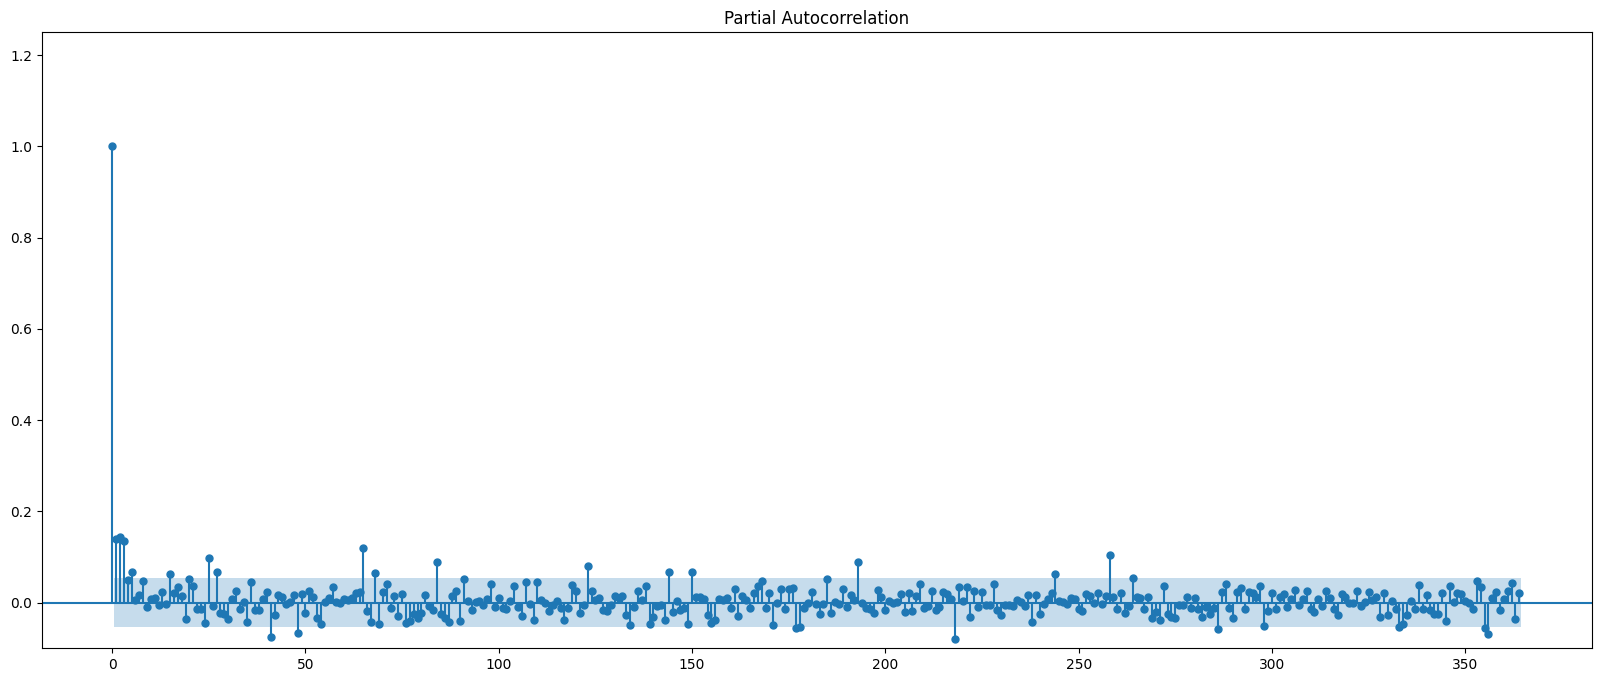

In [23]:
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_pacf(all_data['volume_gm'], 
                     ax = ax, 
                     lags = np.arange(365), 
                     auto_ylims = True, 
                     method='ywm')

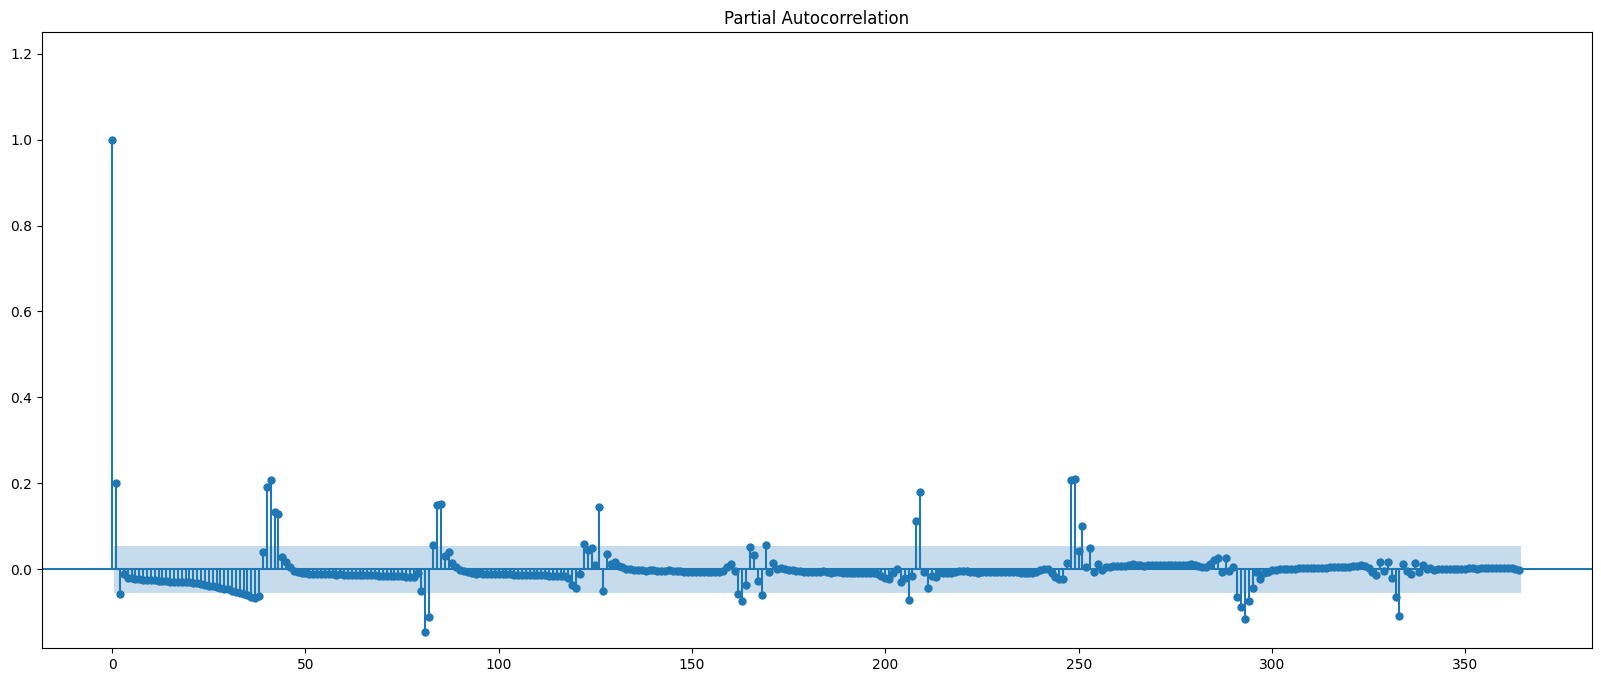

In [98]:
# VOLUME_GOLD
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_pacf(all_data[["volume_gold"]].dropna(), 
                    ax = ax, 
                    lags = np.arange(365), 
                    auto_ylims = True)

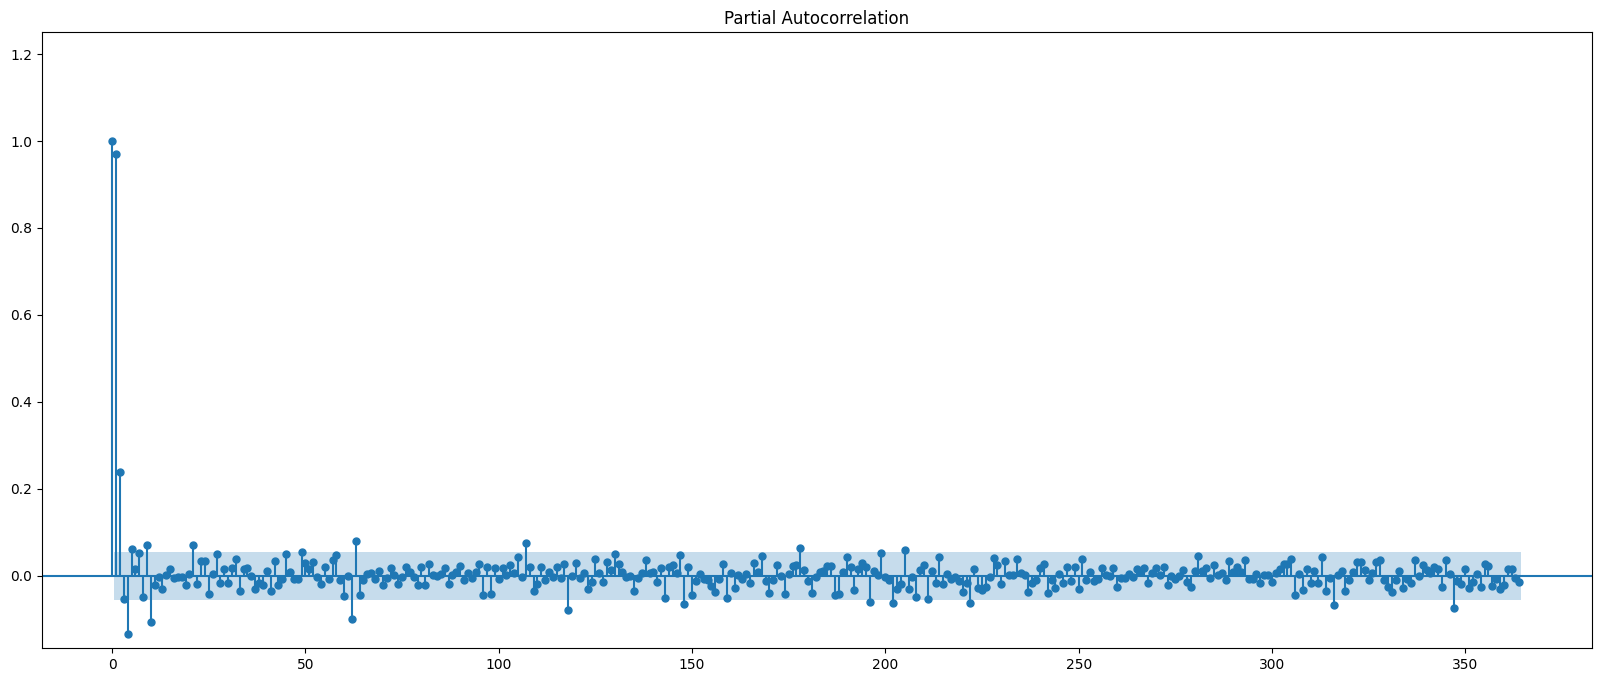

In [99]:
# VIX
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_pacf(all_data[["vix_close_vix"]].dropna(), 
                    ax = ax, 
                    lags = np.arange(365), 
                    auto_ylims = True)

In [117]:
# Add weekday and day of the month
def day_of_week(date_str):
    date_obj = datetime.strptime(date_str, '%m/%d/%Y')
    day_num = date_obj.weekday()  # 0 for Monday, 1 for Tuesday, ..., 6 for Sunday
    return day_num

def day_of_month(date_str):
    return int(date_str.split("/")[1])

def get_month(date_str):
    return int(date_str.split("/")[0])

In [119]:
all_data["day_of_week"] = list(map(day_of_week, all_data.index.tolist()))
all_data["day_of_month"] = list(map(day_of_month, all_data.index.tolist()))
all_data["month"] = list(map(get_month, all_data.index.tolist()))
all_data

volume_gm  vix_close_vix  adj_close_sp500  volume_sp500  \
date                                                                   
1/4/2016   1364.873049          20.70      2012.660034  4.304880e+09   
1/5/2016   4826.624586          19.34      2016.709961  3.706620e+09   
1/6/2016   1751.952884          20.59      1990.260010  4.336660e+09   
1/7/2016   5842.829025          24.99      1943.089966  5.076590e+09   
1/8/2016   1592.794266          27.01      1922.030029  4.664940e+09   
...                ...            ...              ...           ...   
2/10/2021  3190.066116          21.99      3909.879883  4.815380e+09   
2/11/2021  2427.720356          21.25      3916.379883  4.570080e+09   
2/12/2021  3232.310708          19.97      3934.830078  4.119260e+09   
2/15/2021  1950.728704            NaN              NaN           NaN   
2/16/2021  3023.560878          21.46      3932.590088  5.037360e+09   

           adj_close_gold  volume_gold  usd_eurusd  adj_close_bonds  \
date                                                                  
1/4/2016      1075.099976        143.0      1.0898            2.245   
1/5/2016      1078.400024         82.0      1.0746            2.248   
1/6/2016      1091.900024         52.0      1.0742            2.177   
1/7/2016      1107.699951        122.0      1.0868            2.153   
1/8/2016      1097.800049         98.0      1.0861            2.130   
...                   ...          ...         ...              ...   
2/10/2021     1840.599976        543.0      1.2127            1.133   
2/11/2021     1824.900024        602.0      1.2147            1.158   
2/12/2021     1821.599976        259.0      1.2108            1.200   
2/15/2021             NaN          NaN      1.2129              NaN   
2/16/2021     1797.199951       1141.0      1.2143            1.299   

           volume_bonds  day_of_week  day_of_month  month  
date                                                       
1/4/2016            0.0            0             4      1  
1/5/2016            0.0            1             5      1  
1/6/2016            0.0            2             6      1  
1/7/2016            0.0            3             7      1  
1/8/2016            0.0            4             8      1  
...                 ...          ...           ...    ...  
2/10/2021           0.0            2            10      2  
2/11/2021           0.0            3            11      2  
2/12/2021           0.0            4            12      2  
2/15/2021           NaN            0            15      2  
2/16/2021           0.0            1            16      2  

[1328 rows x 12 columns]

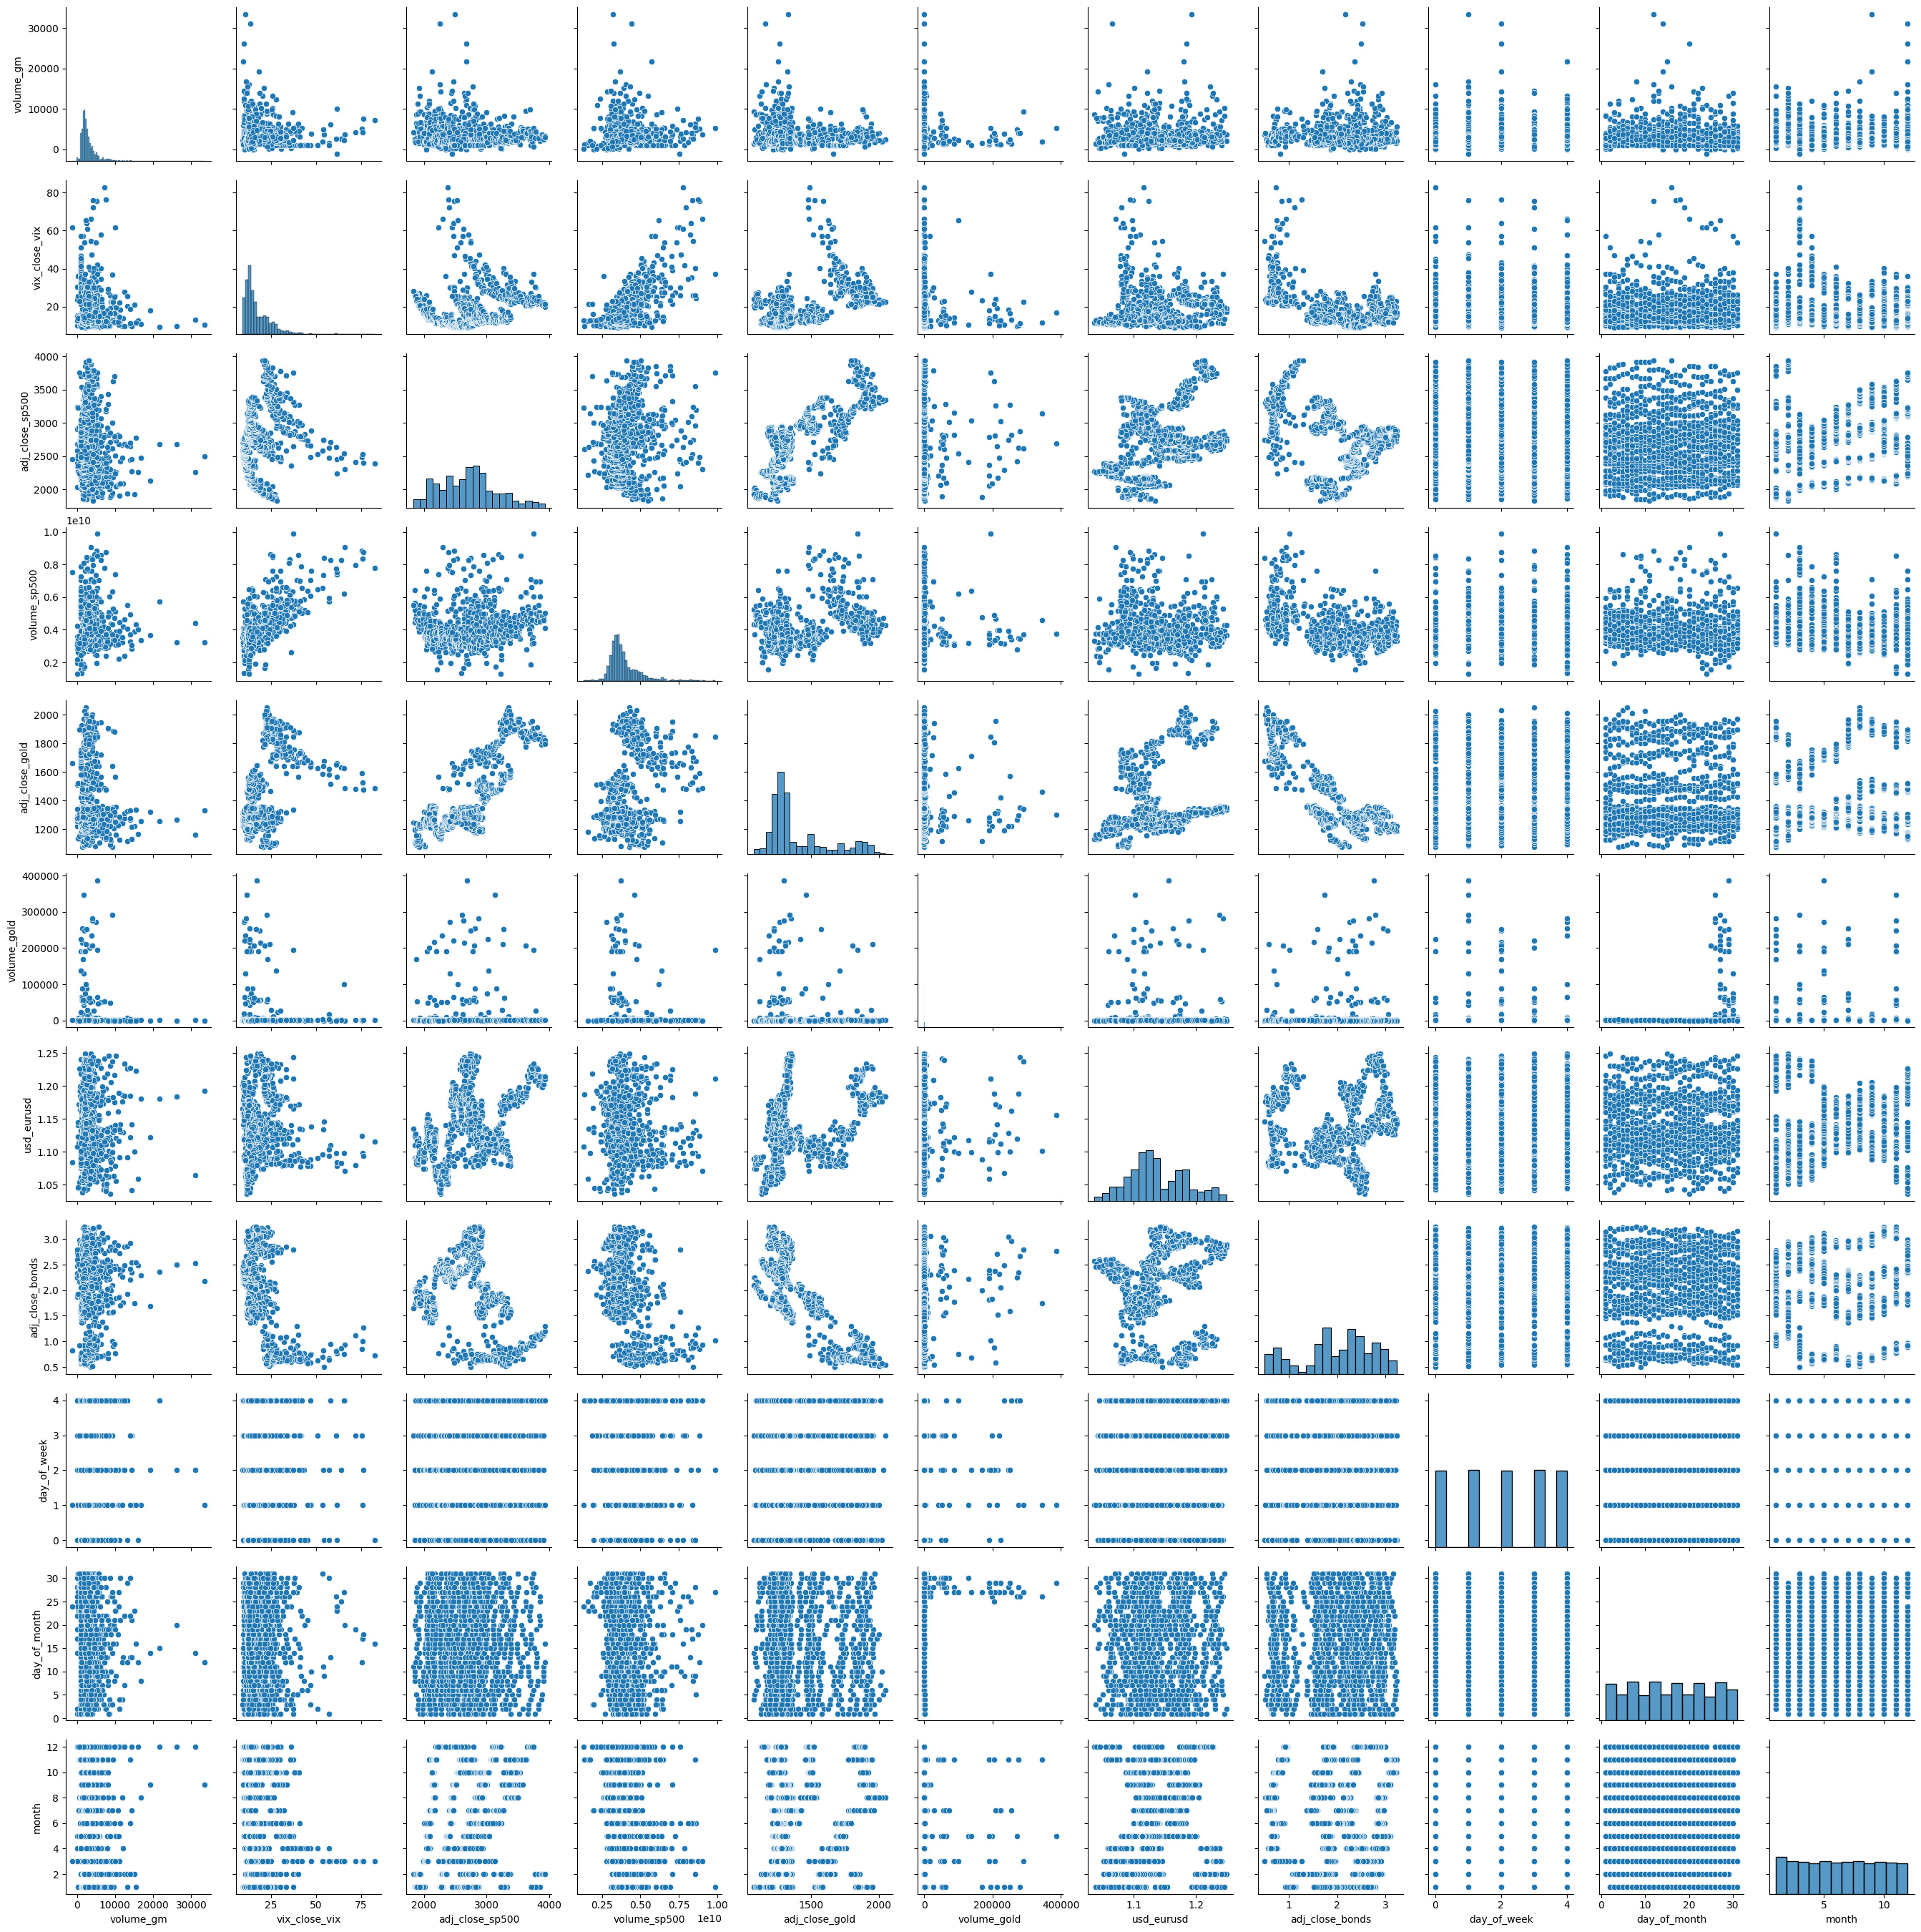

In [120]:
sns.pairplot(all_data.drop(columns=["volume_bonds"]))

In [122]:
# Interpolate to account for missing values

interpolated_data = all_data.interpolate()

<Axes: xlabel='date'>

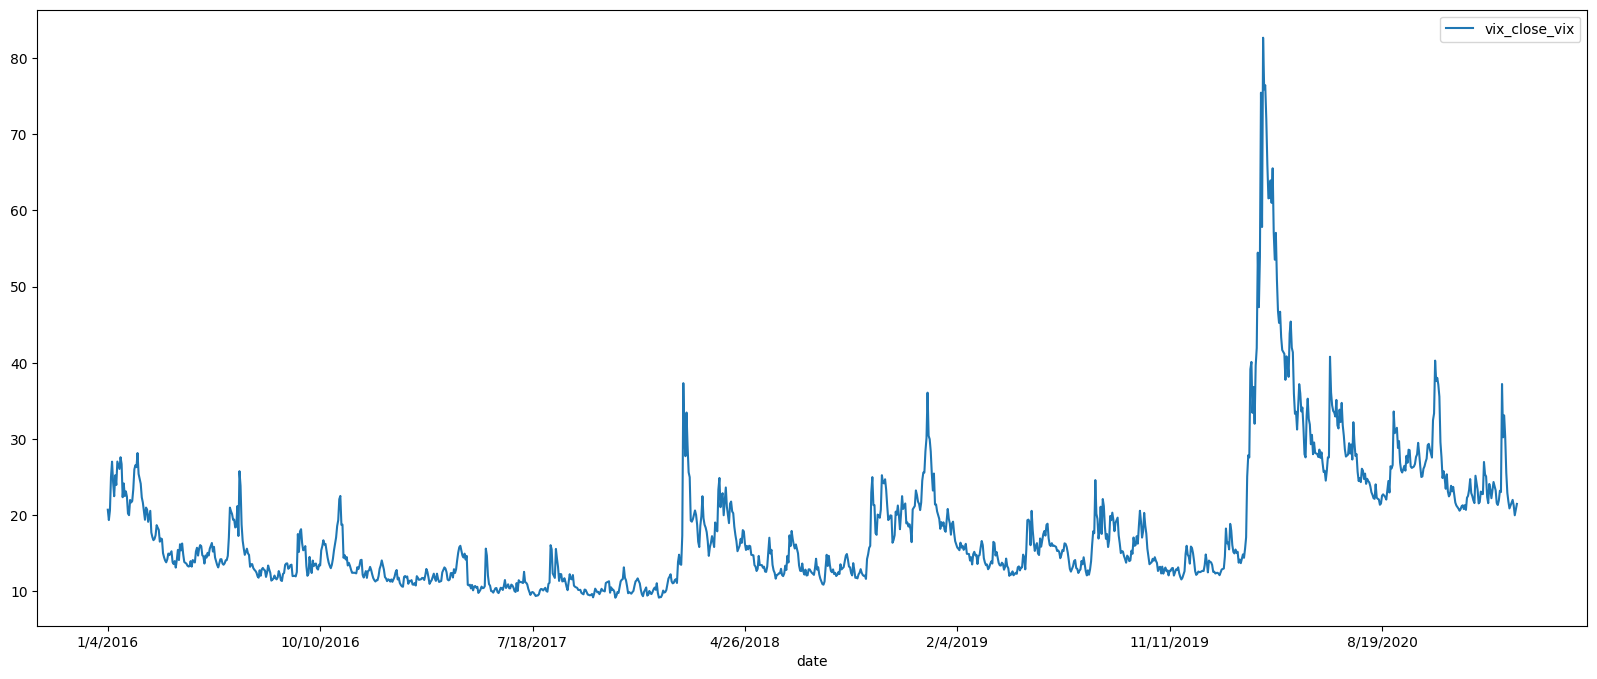

In [123]:
interpolated_data.plot(y='vix_close_vix', figsize=[20, 8])

<Axes: xlabel='date'>

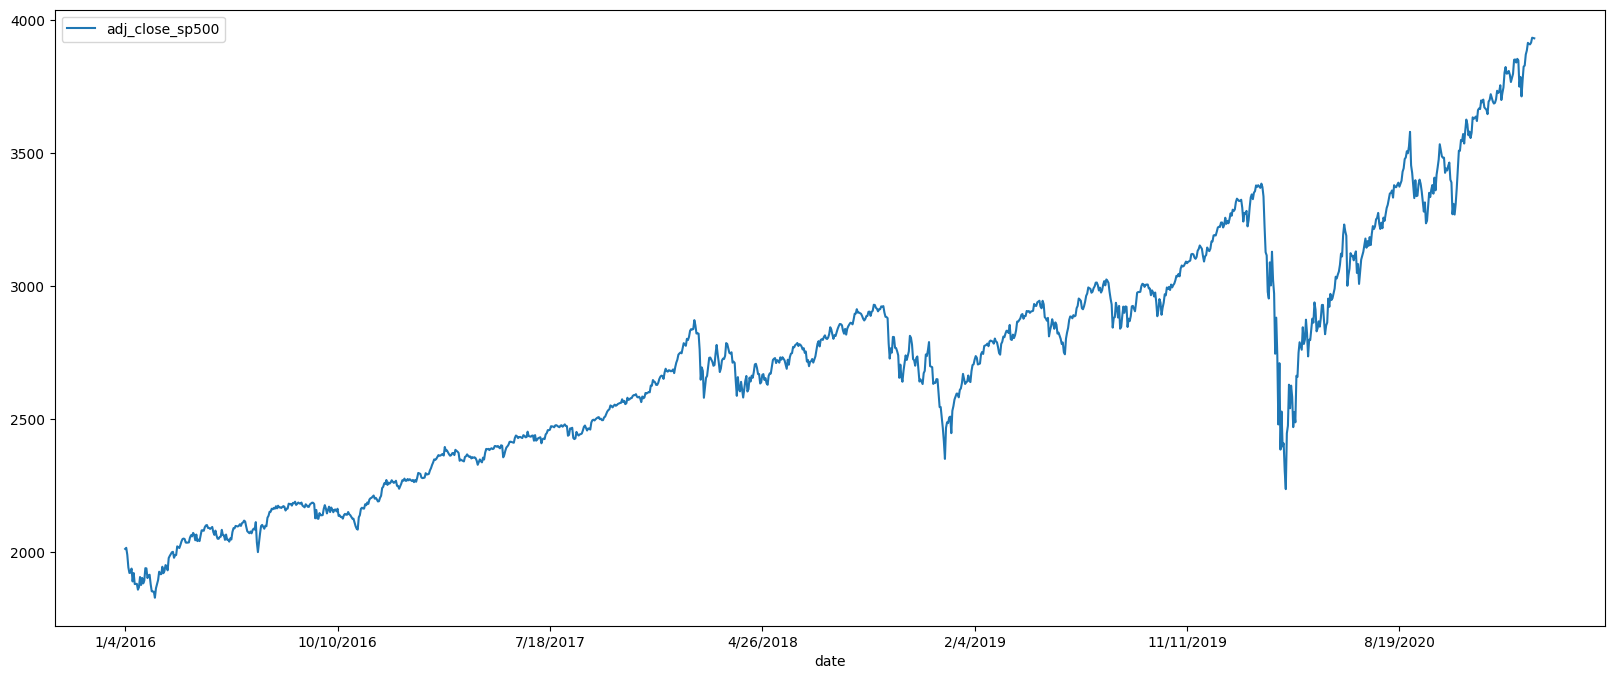

In [124]:
interpolated_data.plot(y='adj_close_sp500', figsize=[20, 8])

<Axes: xlabel='date'>

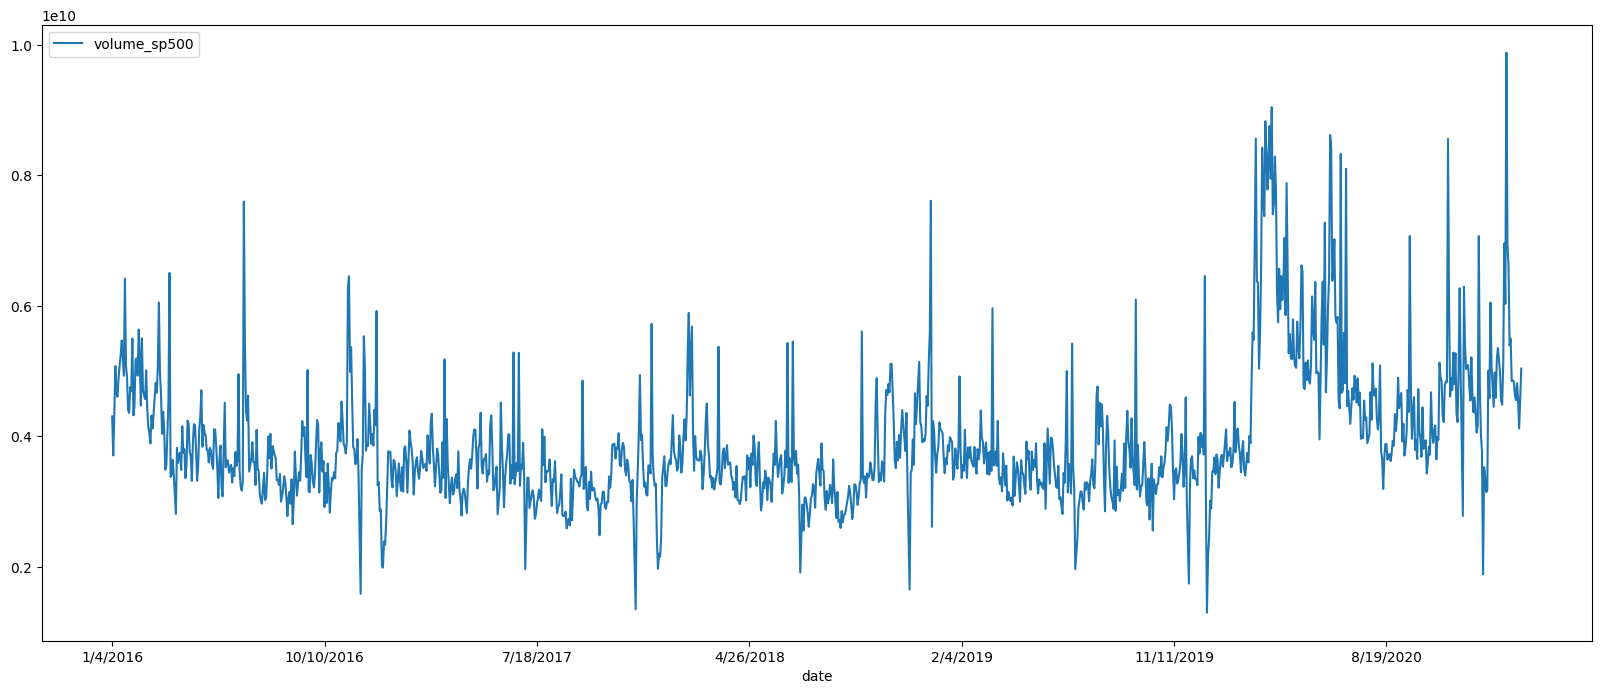

In [125]:
interpolated_data.plot(y='volume_sp500', figsize=[20, 8])

<Axes: xlabel='date'>

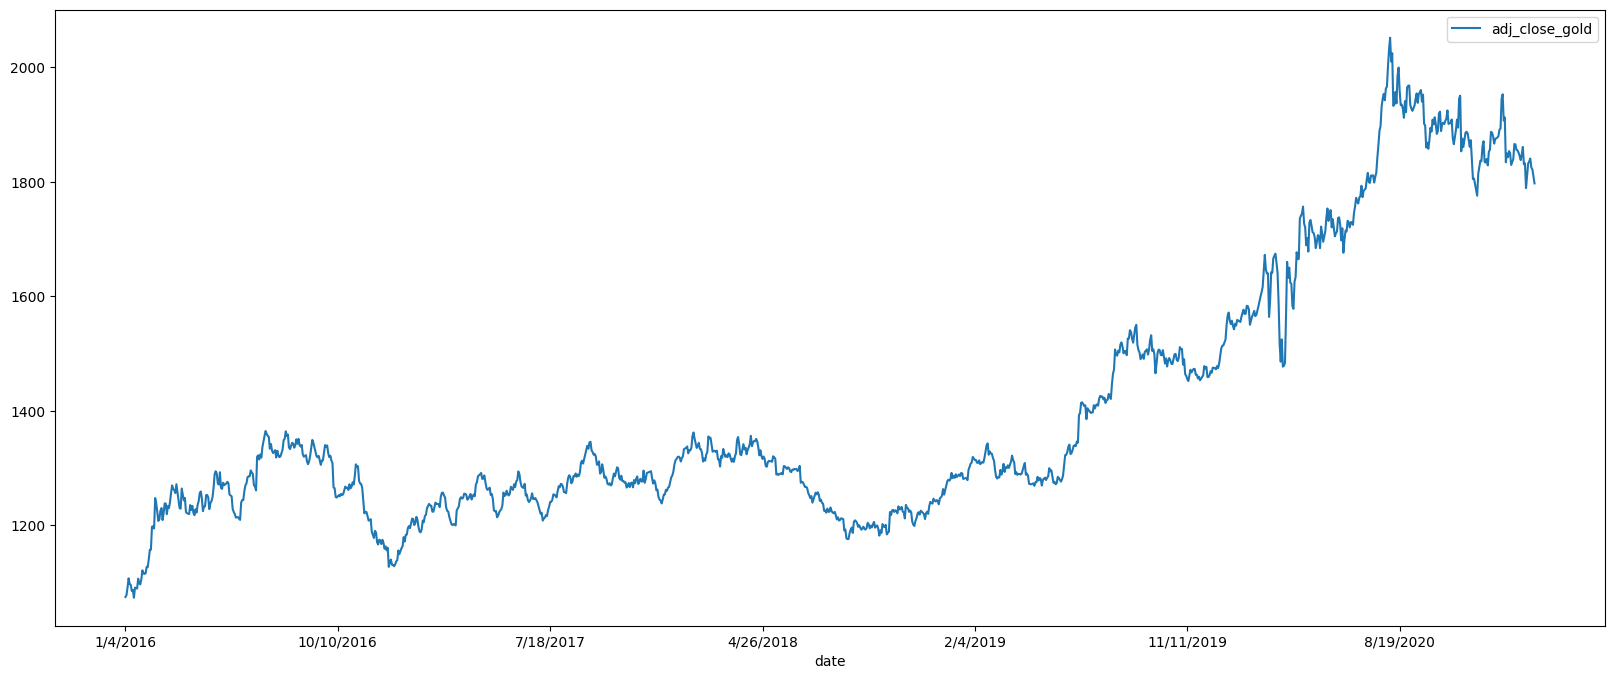

In [126]:
interpolated_data.plot(y='adj_close_gold', figsize=[20, 8])

<Axes: xlabel='date'>

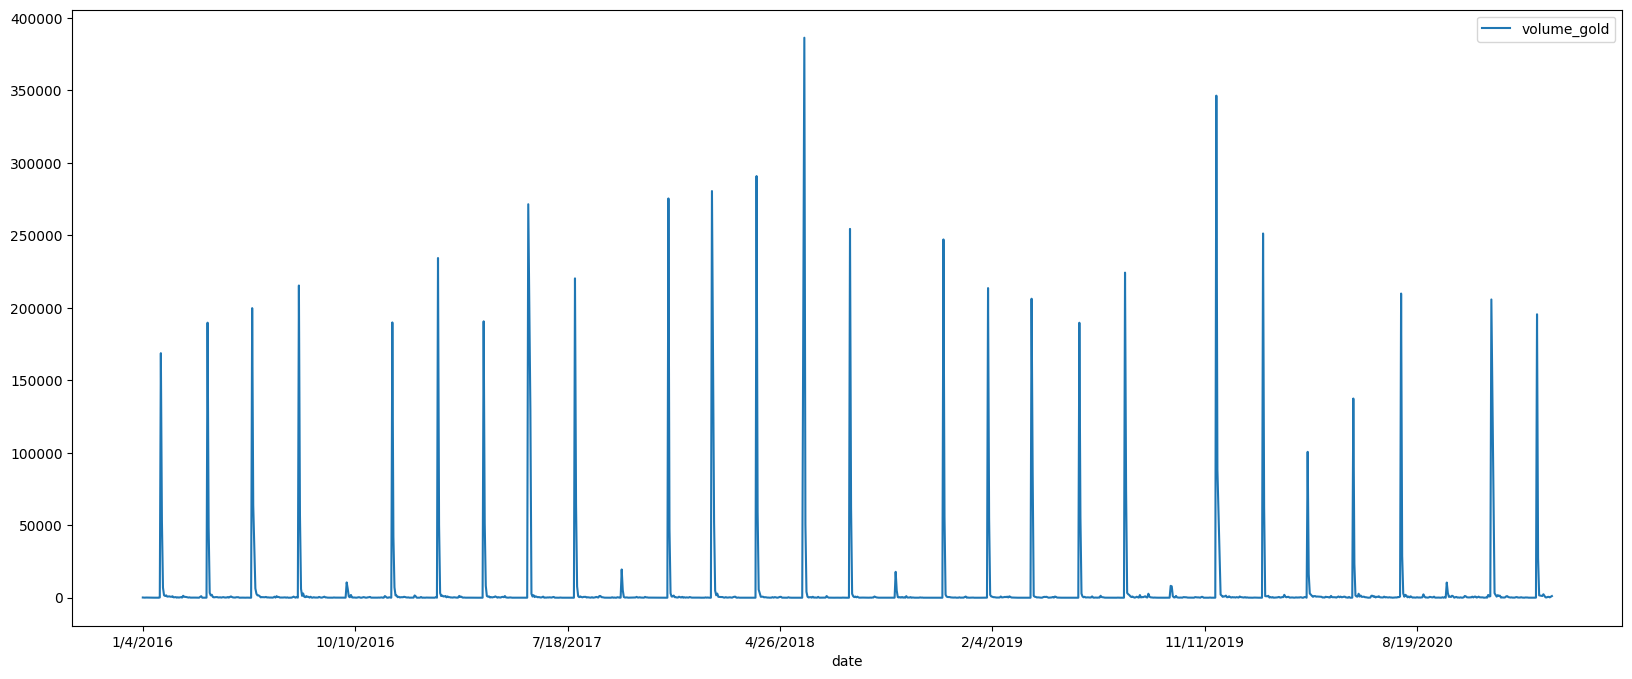

In [127]:
interpolated_data.plot(y='volume_gold', figsize=[20, 8])

<Axes: xlabel='date'>

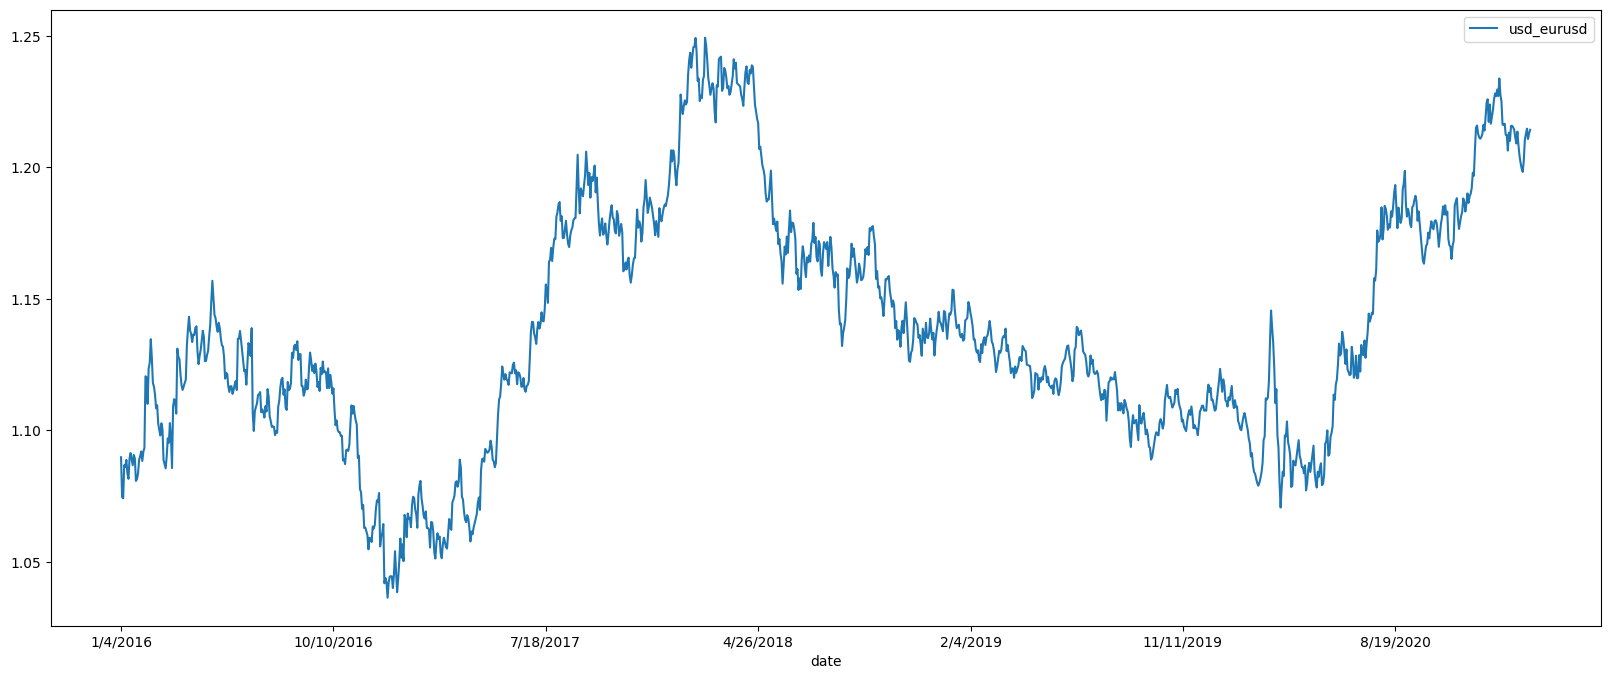

In [128]:
interpolated_data.plot(y='usd_eurusd', figsize=[20, 8])

<Axes: xlabel='date'>

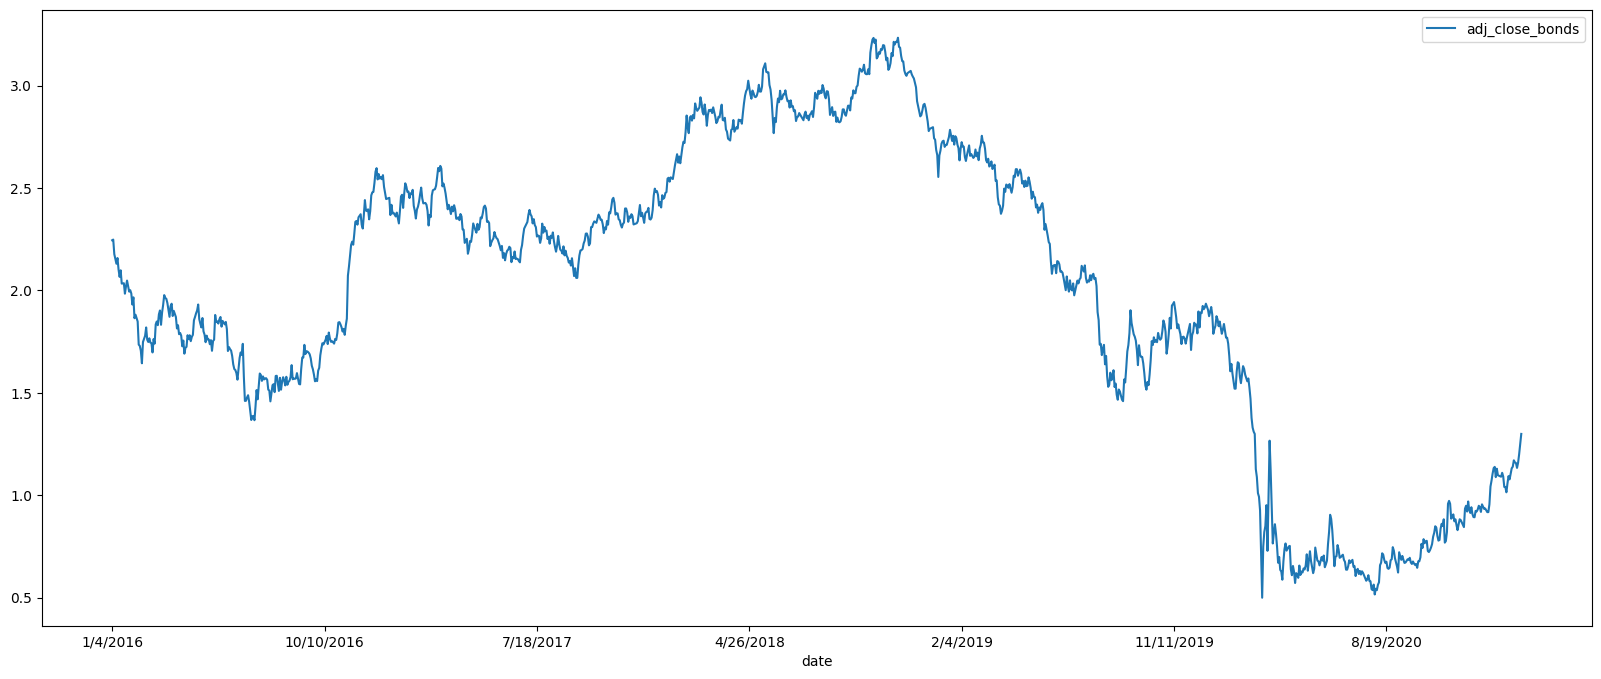

In [129]:
interpolated_data.plot(y='adj_close_bonds', figsize=[20, 8])

In [133]:
all_data[all_data["volume_gm"] == 1000]

volume_gm  vix_close_vix  adj_close_sp500  volume_sp500  \
date                                                                 
4/1/2020      1000.0          57.06      2470.500000  5.947900e+09   
4/2/2020      1000.0          50.91      2526.899902  6.454990e+09   
4/3/2020      1000.0          46.80      2488.649902  6.087190e+09   
4/6/2020      1000.0          45.24      2663.679932  6.391860e+09   
4/7/2020      1000.0          46.70      2659.409912  7.040720e+09   
4/8/2020      1000.0          43.35      2749.979980  5.856370e+09   
4/9/2020      1000.0          41.67      2789.820068  7.880140e+09   
4/10/2020     1000.0            NaN              NaN           NaN   
4/13/2020     1000.0          41.17      2761.629883  5.274310e+09   
4/14/2020     1000.0          37.76      2846.060059  5.567400e+09   
4/15/2020     1000.0          40.84      2783.360107  5.203390e+09   
4/16/2020     1000.0          40.11      2799.550049  5.179990e+09   
4/17/2020     1000.0          38.15      2874.560059  5.792140e+09   
4/20/2020     1000.0          43.83      2823.159912  5.220160e+09   
4/21/2020     1000.0          45.41      2736.560059  5.075830e+09   
4/22/2020     1000.0          41.98      2799.310059  5.049660e+09   
4/23/2020     1000.0          41.38      2797.800049  5.756520e+09   
4/24/2020     1000.0          35.93      2836.739990  5.374480e+09   
4/27/2020     1000.0          33.29      2878.479980  5.194260e+09   
4/28/2020     1000.0          33.57      2863.389893  5.672880e+09   
4/29/2020     1000.0          31.23      2939.510010  6.620140e+09   
4/30/2020     1000.0          34.15      2912.429932  6.523120e+09   
5/1/2020      1000.0          37.19      2830.709961  4.753160e+09   
5/4/2020      1000.0          35.97      2842.739990  4.723140e+09   
5/5/2020      1000.0          33.61      2868.439941  5.129590e+09   
5/6/2020      1000.0          34.12      2848.419922  4.861920e+09   
5/7/2020      1000.0          31.44      2881.189941  5.164640e+09   
5/8/2020      1000.0          27.98      2929.800049  4.857160e+09   
5/11/2020     1000.0          27.57      2930.189941  4.807320e+09   
5/12/2020     1000.0          33.04      2870.120117  5.107710e+09   
5/13/2020     1000.0          35.28      2820.000000  6.143130e+09   
5/14/2020     1000.0          32.61      2852.500000  5.641920e+09   
5/15/2020     1000.0          31.89      2863.699951  5.477040e+09   
5/18/2020     1000.0          29.30      2953.909912  6.364290e+09   
5/19/2020     1000.0          30.53      2922.939941  4.969330e+09   
5/20/2020     1000.0          27.99      2971.610107  4.992970e+09   
5/21/2020     1000.0          29.53      2948.510010  4.966940e+09   
5/22/2020     1000.0          28.16      2955.449951  3.952800e+09   
5/25/2020     1000.0            NaN              NaN           NaN   
5/26/2020     1000.0          28.01      2991.770020  5.837060e+09   
5/27/2020     1000.0          27.62      3036.129883  6.371230e+09   
5/28/2020     1000.0          28.59      3029.729980  5.402670e+09   
5/29/2020     1000.0          27.51      3044.310059  7.275080e+09   

           adj_close_gold  volume_gold  usd_eurusd  adj_close_bonds  \
date                                                                  
4/1/2020      1578.199951       2158.0      1.0936            0.635   
4/2/2020      1625.699951       1294.0      1.0906            0.627   
4/3/2020      1633.699951        643.0      1.0785            0.587   
4/6/2020      1677.000000       1063.0      1.0791            0.676   
4/7/2020      1664.800049       1144.0      1.0885            0.736   
4/8/2020      1665.400024        747.0      1.0871            0.764   
4/9/2020      1736.199951        825.0      1.0867            0.729   
4/10/2020             NaN          NaN         NaN              NaN   
4/13/2020     1744.800049        696.0         NaN            0.749   
4/14/2020     1756.699951        675.0      1.0963            0.752   
4/15/202